# Import packages

In [6]:
!conda install -c conda-forge jupyter_contrib_nbextensions



^C


In [1]:
%matplotlib inline
import matplotlib.colors as mcolors
import cmocean
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib as mpl
import numpy as np 
import pandas as pd
import xarray as xr
import gsw as gsw
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy
import cartopy.crs as ccrs
from scipy.interpolate import PchipInterpolator
from tqdm import tqdm
from glob import glob
import re
#import copernicusmarine
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

mpl.rcParams['figure.facecolor'] = '1'
font = {'family' : 'Sans Serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)
mpl.rcParams['mathtext.default'] = 'regular'

import cartopy.feature
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
import fsspec

In [2]:
adtfile=xr.open_dataset("C:/Users/Thape/Downloads/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D_1737217969350.nc")
adt=adtfile.mean('time')

# Loading IDP Data and non-IDP Data

In [3]:
fname="C:/Users/Thape/Downloads/Untitled Folder/Paper 2/IDP2021_v2_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v2_W8kppWr6/IDP2021_v2_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v2_W8kppWr6.txt"
df = pd.read_csv(fname, delimiter='\t', skiprows=57, on_bad_lines='skip', engine='python', parse_dates=['yyyy-mm-ddThh:mm:ss.sss'])

# Select only important columns for the analysis
df = df[['Cruise', 'Station', 'yyyy-mm-ddThh:mm:ss.sss',
       'Longitude [degrees_east]', 'Latitude [degrees_north]', 'DEPTH [m]', 'CTDTMP_T_VALUE_SENSOR [deg C]',
         'CTDSAL_D_CONC_SENSOR [pss-78]','PHOSPHATE_D_CONC_BOTTLE [umol/kg]','Fe_D_CONC_BOTTLE [nmol/kg]','Mn_D_CONC_BOTTLE [nmol/kg]']]

# Rename columns to be more understandable
df.columns = ['Cruise', 'Station', 'Datetime',
       'Longitude', 'Latitude',
       'Depth',
       'Temp', 'Psal',
       'Phosphate', 'Fe',
       'Mn']
#Read in data not yet in IDP
fname = 'C:/Users/Thape/Downloads/Untitled Folder/Paper 2/IDP_DATA.xlsx'
df2 = pd.read_excel(fname)

df = pd.concat([df, df2])




df['Month'] = df['Datetime'].dt.month  # Extract month as an integer (1-12)

# Drop rows where we don't have all required variables
df = df.dropna(subset=['Fe']).reset_index(drop=True)
#df = df.dropna(subset=['Fe', 'Mn']).reset_index(drop=True)

df = df.loc[df.Latitude <= -27]

# Drop stations if all 3 conditions are not met
df = (
    df.groupby(['Cruise', 'Station'])
    .filter(lambda x: 
            (x['Depth'].lt(50).any()) &            # Condition 1: At least one depth < 50m
            (x['Depth'].gt(400).any()) &           # Condition 2: At least one depth > 400m
            (len(x) >= 5))                         # Condition 3: At least 5 observations per station
)

df_mn = df.dropna(subset=['Mn']).reset_index(drop=True)

# Finally calculate Density
df['Psal_Absolute']  = gsw.SA_from_SP(df.Psal, df.Depth, df.Longitude, df.Latitude)
df['Density'] = gsw.pot_rho_t_exact(df.Psal_Absolute, df.Temp, df.Depth, 0)

df['Density'] = df.groupby(['Cruise', 'Station'])['Density'].transform(lambda x: x.ffill())



# Interpolate samples to uniform depth grid

In [4]:
# Define your target depth grid (modify this as needed)
#target_depth_grid = np.concatenate([np.arange(10, 300, 10), np.arange(300, 1025, 25)])  # Depth range from 10 to 1000m with 10m intervals in upper 300m

target_depth_grid = np.concatenate([np.arange(25, 1025, 25)])  # Depth range from 10 to 1000m with 25 m intervals in upper 300m

# Initialize a list to store the results
interpolated_data = []

# Group by cruise and station
for (cruise, station), group in df.groupby(['Cruise', 'Station']):
    # Sort by depth
    group = group.sort_values(by='Depth')

    # Average duplicate depths by taking the mean of the variables for each depth
    group = group.groupby('Depth').agg({'Fe': 'mean', 'Mn': 'mean', 'Density': 'mean', 'Phosphate': 'mean'}).reset_index()

    # Check if the group has enough data to interpolate
    if len(group['Depth']) < 2:  # Pchip requires at least two points to interpolate
        continue

    # Create a dictionary to hold interpolated values for this cruise and station
    interpolated_values_dict = {'Cruise': cruise, 'Station': station}

    # Interpolate each variable using PchipInterpolator within the depth range of the group
    for var in ['Fe', 'Mn', 'Density', 'Phosphate']:
        # Filter out NaN or non-finite values for the current variable
        valid_data = group[['Depth', var]].dropna()

        # Only interpolate if there are at least two valid points
        if len(valid_data) >= 2:
            # Ensure depth values are strictly increasing
            if np.any(np.diff(valid_data['Depth']) <= 0):
                raise ValueError(f"Depth values for cruise {cruise}, station {station} are not strictly increasing.")
            
            # Ensure data types are numeric (float)
            valid_data['Depth'] = valid_data['Depth'].astype(float)
            valid_data[var] = valid_data[var].astype(float)

            # Perform interpolation
            try:
                interpolator = PchipInterpolator(valid_data['Depth'], valid_data[var], extrapolate=True)
                interpolated_values = interpolator(target_depth_grid)
            except Exception as e:
                continue  # Skip this variable if interpolation fails

            # Explicitly convert to float64 to avoid casting issues later
            interpolated_values = interpolated_values.astype(np.float64)

            # Store interpolated values in dictionary
            interpolated_values_dict[var] = interpolated_values
        else:
            # If not enough valid data points, set interpolated values to NaN for this variable
            interpolated_values_dict[var] = np.full_like(target_depth_grid, np.nan, dtype=np.float64)

    # Add a depth of 0 m, repeating values from 25 m
    for var in ['Fe', 'Mn', 'Density', 'Phosphate']:
        interpolated_values_dict[var] = np.insert(interpolated_values_dict[var], 0, interpolated_values_dict[var][0])

    # Add depth 0 to the target depth grid
    extended_depth_grid = np.insert(target_depth_grid, 0, 0)

    # Now add the interpolated values for each variable to the list of results
    for depth_idx, depth in enumerate(extended_depth_grid):
        # Create a dictionary for this specific depth
        interpolated_data.append({
            'Cruise': cruise,
            'Station': station,
            'Depth': depth,
            'Fe': interpolated_values_dict['Fe'][depth_idx],
            'Mn': interpolated_values_dict['Mn'][depth_idx],
            'Density': interpolated_values_dict['Density'][depth_idx],
            'Phosphate': interpolated_values_dict['Phosphate'][depth_idx],
        })

# Convert the interpolated data list to a DataFrame
interpolated_df = pd.DataFrame(interpolated_data)

# Apply 3-point rolling mean to smooth each variable along the depth axis
interpolated_df['Fe'] = interpolated_df.groupby(['Cruise', 'Station'])['Fe'].rolling(window=3, min_periods=1, center=True).mean().reset_index(level=[0, 1], drop=True)
interpolated_df['Mn'] = interpolated_df.groupby(['Cruise', 'Station'])['Mn'].rolling(window=3, min_periods=1, center=True).mean().reset_index(level=[0, 1], drop=True)
interpolated_df['Density'] = interpolated_df.groupby(['Cruise', 'Station'])['Density'].rolling(window=3, min_periods=1, center=True).mean().reset_index(level=[0, 1], drop=True)
interpolated_df['Phosphate'] = interpolated_df.groupby(['Cruise', 'Station'])['Phosphate'].rolling(window=3, min_periods=1, center=True).mean().reset_index(level=[0, 1], drop=True)

# Reset index for cleaner DataFrame
interpolated_df.reset_index(drop=True, inplace=True)

# Get month info
df_info = df.groupby(['Cruise', 'Station'], as_index=False)[['Month', 'Latitude', 'Longitude']].first()

# Merge this month information into the interpolated_df based on 'Cruise' and 'Station'
interpolated_df = interpolated_df.merge(df_info[['Cruise', 'Station', 'Month', 'Latitude', 'Longitude']], on=['Cruise', 'Station'], how='left')

# Plotting sample locations

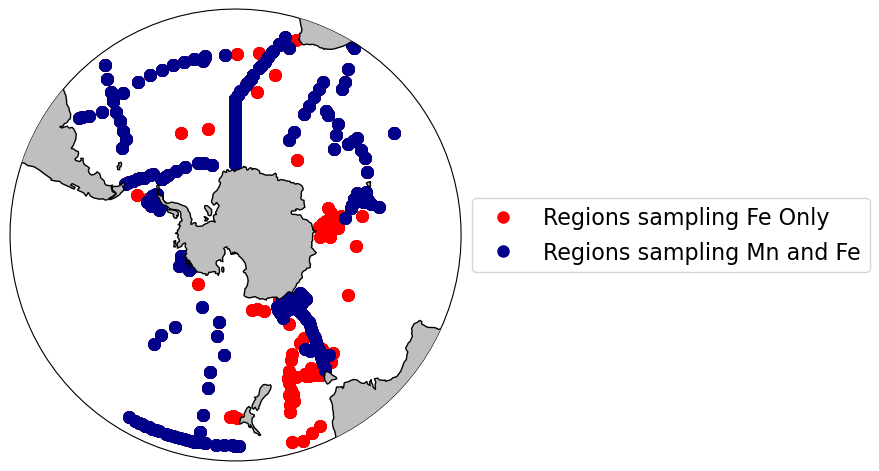

In [5]:
fig = plt.figure(figsize=[10, 5])

# Set up the South Polar projection
ax1 = plt.subplot2grid((1, 1), (0, 0), projection=ccrs.SouthPolarStereo(0))
ax1.add_feature(cartopy.feature.LAND, facecolor='0.75', zorder=5)
ax1.add_feature(cartopy.feature.COASTLINE, linewidth=1, zorder=5)
ax1.set_boundary(circle, transform=ax1.transAxes)
ax1.set_extent([-180, 180, -90, -29], crs=ccrs.PlateCarree())

# Plot Fe data points
sc1 = ax1.plot(df.Longitude, df.Latitude, marker='o', color='r', ms=8, label='Regions sampling Fe Only', lw=0,
                  transform=ccrs.PlateCarree())

# Plot Fe+Mn data points
sc2 = ax1.plot(df_mn.Longitude, df_mn.Latitude, marker='o', color='darkblue', ms=8, label='Regions sampling Mn and Fe', lw=0,
                  transform=ccrs.PlateCarree())

# Add legend and avoid duplicates
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Use dictionary to keep unique labels only
ax1.legend(loc='center left', bbox_to_anchor=[1, 0.5])

# Adjust layout and display the plot
plt.tight_layout()
#plt.savefig('IDPstation.png', bbox_inches='tight', dpi=499)


## Convert to Xarray Dataset

In [5]:
# Step 1: Define bins for Latitude and Longitude
lat_bins = np.arange(-76, -27, 1)  # Latitude bins from -76 to -30 degrees
lon_bins = np.arange(-180, 181, 1)  # Longitude bins from 180 to -179 degrees

# Step 2: Assign each data point to a bin using pd.cut for latitude and longitude
interpolated_df['Lat_bin'] = pd.cut(interpolated_df['Latitude'], bins=lat_bins, labels=lat_bins[:-1], include_lowest=True)
interpolated_df['Lon_bin'] = pd.cut(interpolated_df['Longitude'], bins=lon_bins, labels=lon_bins[:-1], include_lowest=True)

# Step 3: Group by the binned latitude, longitude, and depth and calculate the mean of the variables
grouped = interpolated_df.groupby(['Lat_bin', 'Lon_bin', 'Depth', 'Month'], observed=False).agg({
    'Fe': 'mean',
    'Mn': 'mean',
    'Phosphate': 'mean',
    'Density': 'mean'
}).reset_index()

ds = grouped.set_index(['Lat_bin', 'Lon_bin', 'Depth', 'Month']).to_xarray()
ds = ds.rename({'Lat_bin':'Latitude', 'Lon_bin':'Longitude'})

# Loading manually calculated Winter entrainment data

In [6]:

loc="C:/Users/Thape/Downloads/Untitled Folder/Entrainment_ARGO_Amudsen.xlsx"
file=pd.read_excel(loc)
lats=file['Latitude']
lons=file['Longitude']


file = file.drop_duplicates(subset=['Lat_bin', 'Lon_bin'], keep='first')


# Merging manual data to the xarray

In [111]:
# Initialize the grids for Entrainment, MLD_max, MLD, and MLD_min
entrainment_grid = np.full((len(ds.Latitude), len(ds.Longitude)), np.nan)
mld_max_grid = np.full((len(ds.Latitude), len(ds.Longitude)), np.nan)
mld_grid = np.full((len(ds.Latitude), len(ds.Longitude)), np.nan)
mld_min_grid = np.full((len(ds.Latitude), len(ds.Longitude)), np.nan)
entrainment_Fe = np.full((len(ds.Latitude), len(ds.Longitude)), np.nan)




# Populate the grids by matching Lat_bin and Lon_bin with Latitude and Longitude
for index, row in file.iterrows():
    lat_idx = np.where(ds.Latitude.values == row['Lat_bin'])[0]
    lon_idx = np.where(ds.Longitude.values == row['Lon_bin'])[0]
    if lat_idx.size > 0 and lon_idx.size > 0:
        entrainment_grid[lat_idx[0], lon_idx[0]] = row['Entrainment']
        mld_max_grid[lat_idx[0], lon_idx[0]] = row['MLD']
        mld_grid[lat_idx[0], lon_idx[0]] = row['MLD_max']
        mld_min_grid[lat_idx[0], lon_idx[0]] = row['MLD_min']
        entrainment_Fe[lat_idx[0], lon_idx[0]] = row['EntrainmentFe']

ds['Entrainment'] = (("Latitude", "Longitude"), entrainment_grid)
ds['MLD'] = (("Latitude", "Longitude"), mld_max_grid)
ds['MLD_max'] = (("Latitude", "Longitude"), mld_grid)
ds['MLD_min'] = (("Latitude", "Longitude"), mld_min_grid)
ds['EntrainmentFe'] = (("Latitude", "Longitude"), entrainment_Fe)


detrainment_grid = (mld_min_grid / mld_max_grid) 
detrainment_grid[np.isnan(detrainment_grid)] = np.nan  # Ensure NaN where invalid values exist
ds['Detrainment'] = (("Latitude", "Longitude"), detrainment_grid) 


detrainment_gridfe = (mld_min_grid / mld_max_grid) 
detrainment_gridfe[np.isnan(detrainment_gridfe)] = np.nan  # Ensure NaN where invalid values exist
ds['Detrainment_Fe'] = (("Latitude", "Longitude"), detrainment_gridfe) 
Detrainment_Fe= ds.Detrainment_Fe

detrainment_grid = (mld_min_grid / mld_max_grid)
detrainment_grid[np.isnan(detrainment_grid)] = np.nan  # Ensure NaN where invalid values exist
ds['Detrainment'] = (("Latitude", "Longitude"), detrainment_grid) 
Detrainment= ds.Detrainment*ds.Entrainment

C:\Users\Thape\AppData\Local\Temp\ipykernel_25840\384338302.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  lat_idx = np.where(ds.Latitude.values == row['Lat_bin'])[0]


# Coarsen Fe and Mn results on a 3 deg grid

In [114]:
Entrainment = (ds.Entrainment).coarsen(Latitude=3, Longitude=3, boundary='trim').mean()
Entrainment_Fe = (ds.EntrainmentFe).coarsen(Latitude=3, Longitude=3, boundary='trim').mean()



## Plots of integrated data

#  dMn/dz at theMANGANOCLINE NEARREST

In [15]:
depth_diff = np.diff(ds.Depth.values)
mn_diff = ds.Mn.diff('Depth').mean('Month') 
mn_grad = ((mn_diff/depth_diff)*1000).max('Depth')
ds_grad_mn = mn_grad.coarsen(Latitude=3, Longitude=3, boundary='trim').mean()





depth_diff = np.diff(ds.Depth.values)
fe_diff = ds.Fe.diff('Depth').mean('Month') 
fe_grad = ((fe_diff/depth_diff)*1000).max('Depth')
ds_grad_fe = fe_grad.coarsen(Latitude=3, Longitude=3, boundary='trim').mean()



# dMn/dz at the MLD

In [16]:
depth_diff = np.diff(ds.Depth.values)
depth_mask = ds.Depth <= ds.MLD
mn_diff = ds.Mn.where(depth_mask).diff('Depth').mean('Month')
mn_grad = ((mn_diff / depth_diff) * 1000).where(depth_mask).max('Depth')
ds_grad_mn3 = mn_grad.coarsen(Latitude=3, Longitude=3, boundary='trim').mean()

depth_diff = np.diff(ds.Depth.values)
depth_mask = ds.Depth <= ds.MLD
fe_diff = ds.Fe.where(depth_mask).diff('Depth').mean('Month')
fe_grad = ((fe_diff / depth_diff) * 1000).where(depth_mask).max('Depth')
ds_grad_fe3 = fe_grad.coarsen(Latitude=3, Longitude=3, boundary='trim').mean()

# dMn/dz at the MLDMAX

In [17]:
depth_diff = np.diff(ds.Depth.values)
depth_mask = ds.Depth <= ds.MLD_max
mn_diff = ds.Mn.where(depth_mask).diff('Depth').mean('Month')
mn_grad = ((mn_diff / depth_diff) * 1000).where(depth_mask).max('Depth')
ds_grad_mn3 = mn_grad.coarsen(Latitude=3, Longitude=3, boundary='trim').mean()

depth_diff = np.diff(ds.Depth.values)
depth_mask = ds.Depth <= ds.MLD_max
fe_diff = ds.Fe.where(depth_mask).diff('Depth').mean('Month')
fe_grad = ((fe_diff / depth_diff) * 1000).where(depth_mask).max('Depth')
ds_grad_fe3 = fe_grad.coarsen(Latitude=3, Longitude=3, boundary='trim').mean()

# Plot gradients a nutricline and MLD

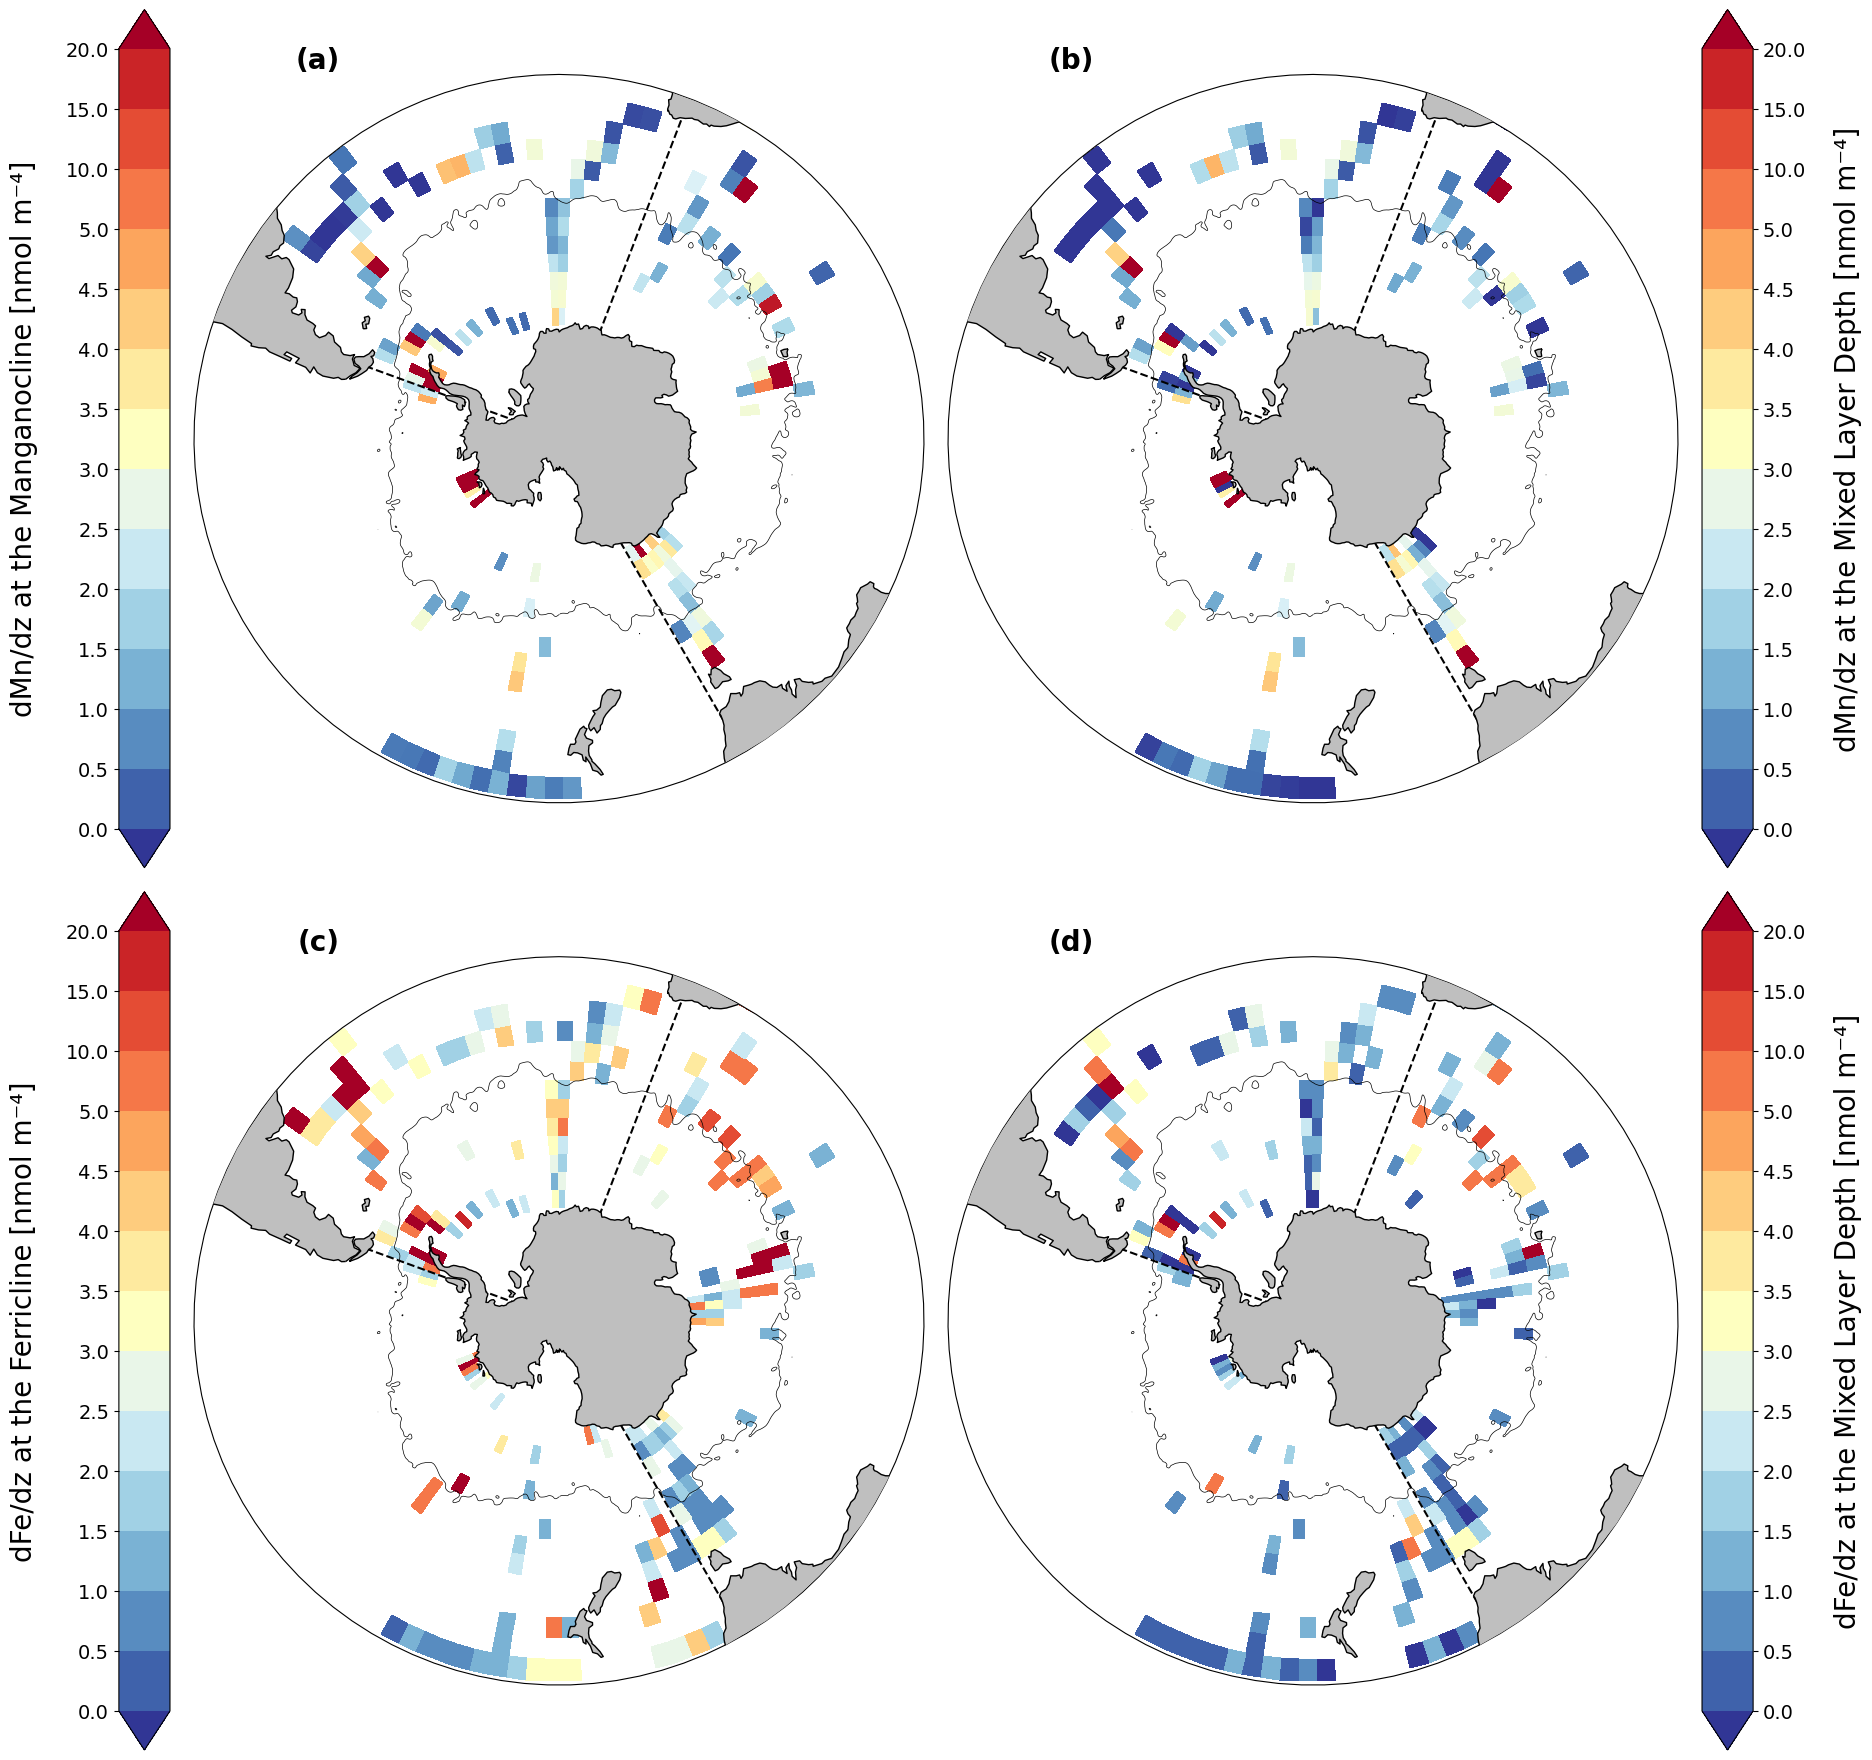

In [36]:
fig = plt.figure(figsize=(19, 18))
gs = fig.add_gridspec(2, 4, width_ratios=[0.07, 1, 1, 0.07], height_ratios=[1, 1])

projection = ccrs.SouthPolarStereo(central_longitude=0)
extent = [-180, 180, -90, -31]
transform = ccrs.RotatedPole(pole_longitude=180.0, pole_latitude=90.0, central_rotated_longitude=0.0)
land_feature = cartopy.feature.LAND
coastline_feature = cartopy.feature.COASTLINE

vmin_mn, vmax_mn = 40, 120
ax0 = fig.add_subplot(gs[0, 1], projection=projection)
ax0.add_feature(land_feature, facecolor='0.75', zorder=5)
ax0.add_feature(coastline_feature, linewidth=1, zorder=5)
ax0.set_extent(extent, crs=ccrs.PlateCarree())
ax0.set_boundary(circle, transform=ax0.transAxes)
levels = [-0.48]
contour = ax0.contour(
adt.longitude,  # or the appropriate coordinate name
adt.latitude,   # or the appropriate coordinate name
adt.adt,    # the DataArray
levels=levels,
linewidths=0.5,
linestyles='-',
colors='black',
transform=ccrs.PlateCarree())

import matplotlib.colors as mcolors

# Define discrete levels (matching those in the image)
levels = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5,10,15,20]

# Create a normalizer for the colormap
norm = mcolors.BoundaryNorm(levels, ncolors=256, extend='both')
im_mn = ds_grad_mn.plot(
    ax=ax0, vmin=0, vmax=5.5, cmap='RdYlBu_r',
    add_colorbar=False, transform=transform)

# Define the colorbar axis
cbar_fe_ax = fig.add_subplot(gs[0, 0])

# Create the colorbar with discrete levels
cbar_fe = fig.colorbar(im_fe, cax=cbar_fe_ax, orientation='vertical', extend='both', ticks=levels)

# Set label
cbar_fe.set_label('dMn/dz at the Manganocline [nmol m⁻⁴]', labelpad=20, fontsize=20)

# Set tick parameters
cbar_fe.ax.tick_params(labelsize=14)

cbar_fe.ax.yaxis.set_ticks_position('left')
cbar_fe.ax.yaxis.set_label_position('left')

ax0.text(0.2, 1, '(a)', transform=ax0.transAxes, fontsize=20, fontweight='bold', va='bottom', ha='right')
ax0.plot([-70, -70], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='black')  # Atlantic
ax0.plot([21, 21], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='black')   # Indian
ax0.plot([150, 150], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='black') # Pacific
# --- Panel (b)
ax1 = fig.add_subplot(gs[0, 2], projection=projection)
ax1.add_feature(land_feature, facecolor='0.75', zorder=5)
ax1.add_feature(coastline_feature, linewidth=1, zorder=5)
ax1.set_extent(extent, crs=ccrs.PlateCarree())
ax1.set_boundary(circle, transform=ax1.transAxes)
levels = [-0.48]
contour = ax1.contour(
adt.longitude,  # or the appropriate coordinate name
adt.latitude,   # or the appropriate coordinate name
adt.adt,    # the DataArray
levels=levels,
linewidths=0.5,
linestyles='-',
colors='black',
transform=ccrs.PlateCarree())
levels = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5,10,15,20]

# Create a normalizer for the colormap
norm = mcolors.BoundaryNorm(levels, ncolors=256, extend='both')
im_mn = ds_grad_mn3.plot(
    ax=ax1, vmin=0, vmax=5.5, cmap='RdYlBu_r',
    add_colorbar=False, transform=transform)


cbar_fe_ax = fig.add_subplot(gs[0, 3])
cbar_fe = fig.colorbar(im_fe, cax=cbar_fe_ax, orientation='vertical', extend='both', ticks=levels)
cbar_fe.set_label('dMn/dz at the Mixed Layer Depth [nmol m⁻⁴]', labelpad=20, fontsize=20)
cbar_fe.ax.tick_params(labelsize=14)
ax1.plot([-70, -70], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='black')  # Atlantic
ax1.plot([21, 21], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='black')   # Indian
ax1.plot([150, 150], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='black') # Pacific
ax1.text(0.2, 1, '(b)', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='bottom', ha='right')

# --- Panel (c)
projection = ccrs.SouthPolarStereo(central_longitude=0)
extent = [-180, 180, -90, -31]
transform = ccrs.RotatedPole(pole_longitude=180.0, pole_latitude=90.0, central_rotated_longitude=0.0)
land_feature = cartopy.feature.LAND
coastline_feature = cartopy.feature.COASTLINE

vmin_mn, vmax_mn = 40, 120
ax0 = fig.add_subplot(gs[1, 1], projection=projection)
ax0.add_feature(land_feature, facecolor='0.75', zorder=5)
ax0.add_feature(coastline_feature, linewidth=1, zorder=5)
ax0.set_extent(extent, crs=ccrs.PlateCarree())
ax0.set_boundary(circle, transform=ax0.transAxes)
levels = [-0.48]
contour = ax0.contour(
adt.longitude,  # or the appropriate coordinate name
adt.latitude,   # or the appropriate coordinate name
adt.adt,    # the DataArray
levels=levels,
linewidths=0.5,
linestyles='-',
colors='black',
transform=ccrs.PlateCarree())

import matplotlib.colors as mcolors

# Define discrete levels (matching those in the image)
levels = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5,10,15,20]

# Create a normalizer for the colormap
norm = mcolors.BoundaryNorm(levels, ncolors=256, extend='both')
im_fe = ds_grad_fe.plot(
    ax=ax0, vmin=0, vmax=20, cmap='RdYlBu_r', norm=norm,
    add_colorbar=False, transform=transform)

# Define the colorbar axis
cbar_fe_ax = fig.add_subplot(gs[1, 0])

# Create the colorbar with discrete levels
cbar_fe = fig.colorbar(im_fe, cax=cbar_fe_ax, orientation='vertical', extend='both', ticks=levels)

# Set label
cbar_fe.set_label('dFe/dz at the Ferricline [nmol m⁻⁴]', labelpad=20, fontsize=20)

# Set tick parameters
cbar_fe.ax.tick_params(labelsize=14)

cbar_fe.ax.yaxis.set_ticks_position('left')
cbar_fe.ax.yaxis.set_label_position('left')

ax0.text(0.2, 1, '(c)', transform=ax0.transAxes, fontsize=20, fontweight='bold', va='bottom', ha='right')
ax0.plot([-70, -70], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='black')  # Atlantic
ax0.plot([21, 21], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='black')   # Indian
ax0.plot([150, 150], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='black') # Pacific
# --- Panel (d)
ax3 = fig.add_subplot(gs[1, 2], projection=projection)
ax3.add_feature(land_feature, facecolor='0.75', zorder=5)
ax3.add_feature(coastline_feature, linewidth=1, zorder=5)
ax3.set_extent(extent, crs=ccrs.PlateCarree())
ax3.set_boundary(circle, transform=ax3.transAxes)




im_fe3 = ds_grad_fe3.plot(
    ax=ax3, vmin=0, vmax=20, cmap='RdYlBu_r', norm=norm,
    add_colorbar=False, transform=transform)

cbar_fe3_ax = fig.add_subplot(gs[1, 3])
cbar_fe3 = fig.colorbar(im_fe3, cax=cbar_fe3_ax, orientation='vertical', extend='both', ticks=levels)
cbar_fe3.set_label('dFe/dz at the Mixed Layer Depth [nmol m⁻⁴]', labelpad=20, fontsize=20)
cbar_fe3.ax.tick_params(labelsize=14)

ax3.text(0.2, 1, '(d)', transform=ax3.transAxes, fontsize=20, fontweight='bold', va='bottom', ha='right')


ax3.plot([-70, -70], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='black')  # Atlantic
ax3.plot([21, 21], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='black')   # Indian
ax3.plot([150, 150], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='black') # Pacific


levels = [-0.48]
contour = ax3.contour(
adt.longitude,  # or the appropriate coordinate name
adt.latitude,   # or the appropriate coordinate name
adt.adt,    # the DataArray
levels=levels,
linewidths=0.5,
linestyles='-',
colors='black',
transform=ccrs.PlateCarree())


plt.tight_layout()
plt.savefig('F1.png', bbox_inches='tight', dpi=499)


# MANGANOCLINE AND MLD

In [18]:
depth_diff = np.diff(ds.Depth.values)
mn_diff = ds.Mn.diff('Depth').mean('Month') 
mn_grad = ((mn_diff / depth_diff) * 1000)  # Gradient calculation


max_grad = mn_grad.max('Depth')  
depth_at_max_grad = mn_grad.idxmax('Depth')

#depth_at_max_grad = mn_grad.sel(Depth=mn_grad.idxmax('Depth'), method='nearest')

# Coarsen the dataset for spatial averaging
ds_grad_mn = max_grad.coarsen(Latitude=3, Longitude=3, boundary='trim').mean()
ds_depth_at_max_grad = depth_at_max_grad.coarsen(Latitude=3, Longitude=3, boundary='trim').mean()





depth_diff = np.diff(ds.Depth.values)
fe_diff = ds.Fe.diff('Depth').mean('Month') 
fe_grad = ((fe_diff / depth_diff) * 1000)  # Gradient calculation


max_gradfe = fe_grad.max('Depth')  
depth_at_max_gradfe = fe_grad.idxmax('Depth')

#depth_at_max_grad = mn_grad.sel(Depth=mn_grad.idxmax('Depth'), method='nearest')

# Coarsen the dataset for spatial averaging
ds_grad_fe = max_gradfe.coarsen(Latitude=3, Longitude=3, boundary='trim').mean()
ds_depth_at_max_gradfe = depth_at_max_gradfe.coarsen(Latitude=3, Longitude=3, boundary='trim').mean()



<xarray.Dataset> Size: 273MB
Dimensions:         (Latitude: 48, Longitude: 360, Depth: 41, Month: 12)
Coordinates:
  * Latitude        (Latitude) int32 192B -76 -75 -74 -73 ... -32 -31 -30 -29
  * Longitude       (Longitude) int32 1kB -180 -179 -178 -177 ... 177 178 179
  * Depth           (Depth) int32 164B 0 25 50 75 100 ... 900 925 950 975 1000
  * Month           (Month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    Fe              (Latitude, Longitude, Depth, Month) float64 68MB nan ... nan
    Mn              (Latitude, Longitude, Depth, Month) float64 68MB nan ... nan
    Phosphate       (Latitude, Longitude, Depth, Month) float64 68MB nan ... nan
    Density         (Latitude, Longitude, Depth, Month) float64 68MB nan ... nan
    Entrainment     (Latitude, Longitude) float64 138kB nan nan nan ... nan nan
    MLD             (Latitude, Longitude) float64 138kB nan nan nan ... nan nan
    MLD_max         (Latitude, Longitude) float64 138kB nan nan nan ... nan nan
    MLD_min         (Latitude, Longitude) float64 138kB nan nan nan ... nan nan
    EntrainmentFe   (Latitude, Longitude) float64 138kB nan nan nan ... nan nan
    Detrainment     (Latitude, Longitude) float64 138kB nan nan nan ... nan nan
    Detrainment_Fe  (Latitude, Longitude) float64 138kB nan nan nan ... nan nan

# Sigma density anomaly

In [19]:
density = ds.Density.mean(['Depth', 'Month'])  # Compute mean over Depth and Month  
density_min = density.min()  # Minimum of the mean density  
density_max = density.max()  # Maximum of the mean density  

density = xr.where(ds.Density < density_min, density_min, ds.Density)  
density = xr.where(density > density_max, density_max, density)  

#970-1028

density = ds.Density  


# Mask density values where Depth does not match depth_at_max_gradfe
density_at_max_gradmn = density.where(ds.Depth == depth_at_max_grad)

# Average over months
density_at_max_gradmn = density_at_max_gradmn.mean('Month')

# Convert to sigma density (subtract 1000)
density_at_max_gradmn = density_at_max_gradmn - 1000

# Apply spatial coarsening (only where data exists)
density_at_max_gradmn = density_at_max_gradmn.mean('Depth').coarsen(Latitude=3, Longitude=3, boundary='trim').mean()

# Compute the mean value
density_at_max_grad_meanmn = density_at_max_gradmn.mean()


In [20]:


# Mask density values where Depth does not match depth_at_max_gradfe
density_at_max_grad = density.where(ds.Depth == depth_at_max_gradfe)

# Average over months
density_at_max_grad = density_at_max_grad.mean('Month')

# Convert to sigma density (subtract 1000)
density_at_max_grad = density_at_max_grad - 1000

# Apply spatial coarsening (only where data exists)
density_at_max_grad = density_at_max_grad.mean('Depth').coarsen(Latitude=3, Longitude=3, boundary='trim').mean()

# Compute the mean value
density_at_max_grad_mean = density_at_max_grad.mean()




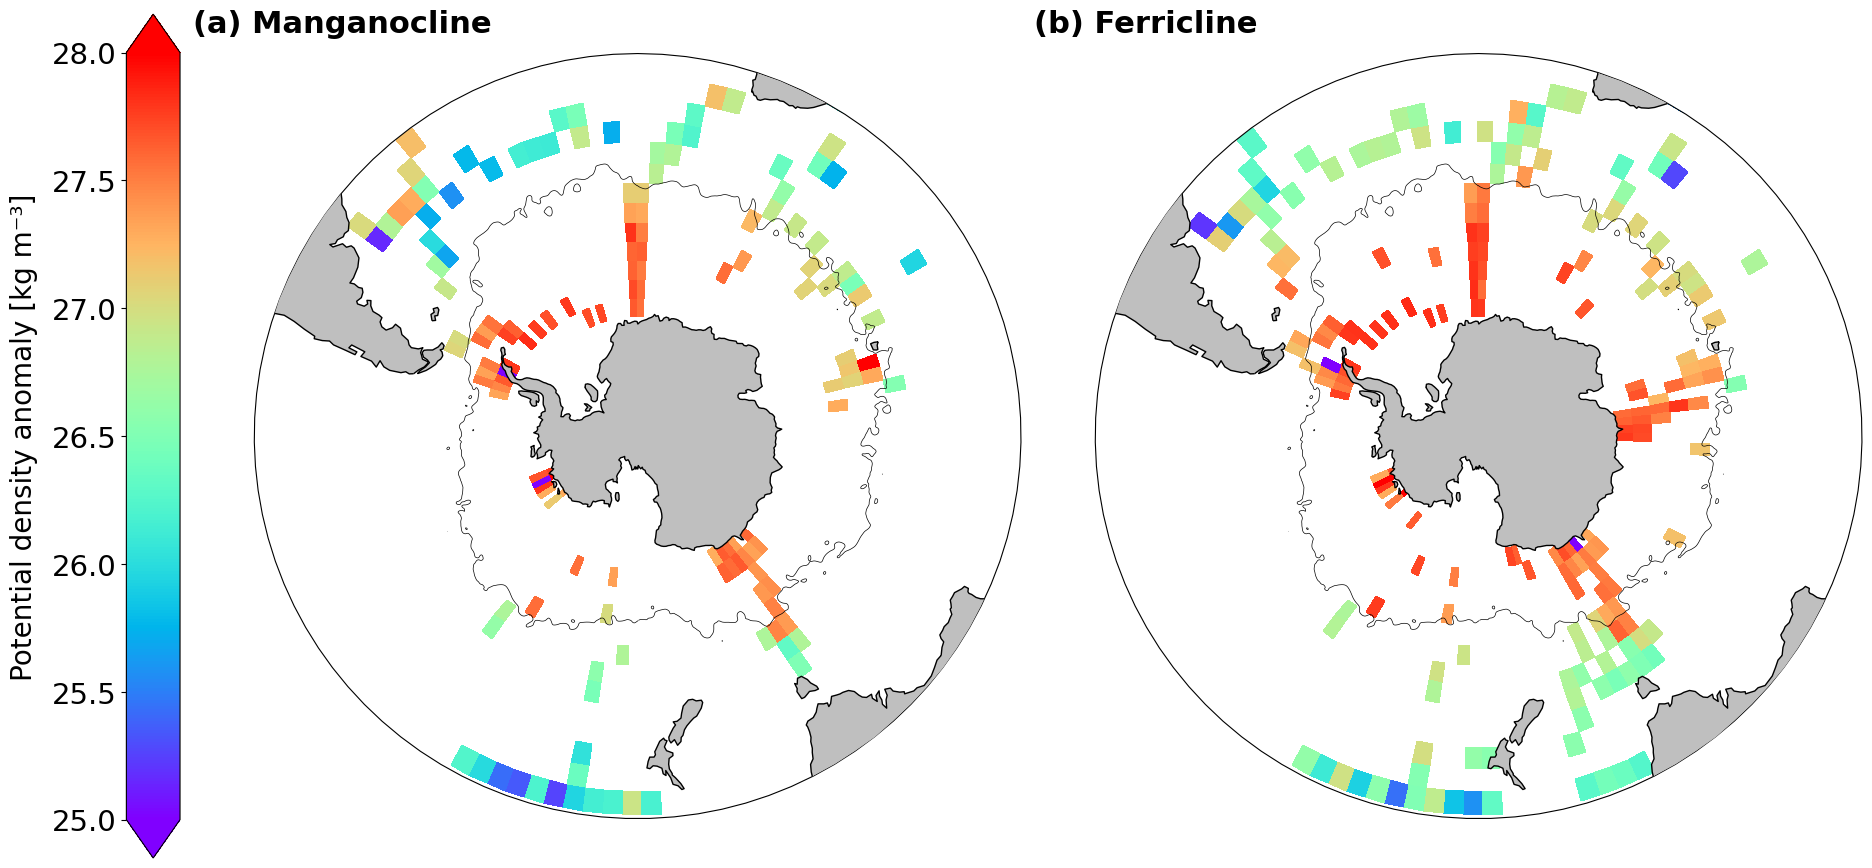

In [204]:
fig = plt.figure(figsize=(19, 9))
gs = fig.add_gridspec(1, 3, width_ratios=[0.07, 1, 1]) 

projection = ccrs.SouthPolarStereo(central_longitude=0)
extent = [-180, 180, -90, -31]
transform = ccrs.RotatedPole(pole_longitude=180.0, pole_latitude=90.0, central_rotated_longitude=0.0)
land_feature = cartopy.feature.LAND
coastline_feature = cartopy.feature.COASTLINE

vmin_mn, vmax_mn = 40, 120
ax0 = fig.add_subplot(gs[0, 1], projection=projection)
ax0.add_feature(land_feature, facecolor='0.75', zorder=5)
ax0.add_feature(coastline_feature, linewidth=1, zorder=5)
ax0.set_extent(extent, crs=ccrs.PlateCarree())
ax0.set_boundary(circle, transform=ax0.transAxes)

im_mn = density_at_max_gradmn.plot(
    ax=ax0, vmin=25, vmax=28, cmap='rainbow',
    add_colorbar=False, transform=transform
)

 

levels = [-0.48]
contour = ax0.contour(
adt.longitude,  # or the appropriate coordinate name
adt.latitude,   # or the appropriate coordinate name
adt.adt,    # the DataArray
levels=levels,
linewidths=0.5,
linestyles='-',
colors='black',
transform=ccrs.PlateCarree())

# Add subplot label (a) Mn
ax0.text(-0.08, 1.02, "(a) Manganocline", transform=ax0.transAxes, fontsize=22, fontweight="bold", va="bottom")

cbar_mn_ax = fig.add_subplot(gs[0, 0])
cbar_mn = fig.colorbar(im_mn, cax=cbar_mn_ax, orientation='vertical', extend='both')
cbar_mn.set_label('Potential density anomaly [kg m⁻³]', labelpad=10, fontsize=20)
cbar_mn.ax.yaxis.set_ticks_position('left')
cbar_mn.ax.yaxis.set_label_position('left')
cbar_mn.ax.tick_params(labelsize=21)

vmin_fe, vmax_fe = 10, 60
ax1 = fig.add_subplot(gs[0, 2], projection=projection)
ax1.add_feature(land_feature, facecolor='0.75', zorder=5)
ax1.add_feature(coastline_feature, linewidth=1, zorder=5)
ax1.set_extent(extent, crs=ccrs.PlateCarree())
ax1.set_boundary(circle, transform=ax1.transAxes)

im_fe = density_at_max_grad.plot(
    ax=ax1, vmin=25, vmax=28, cmap='rainbow',
    add_colorbar=False, transform=transform
)

# Add subplot label (b) Fe
ax1.text(-0.08, 1.02, "(b) Ferricline", transform=ax1.transAxes, fontsize=22, fontweight="bold", va="bottom")
levels = [-0.48]
contour = ax1.contour(
adt.longitude,  # or the appropriate coordinate name
adt.latitude,   # or the appropriate coordinate name
adt.adt,    # the DataArray
levels=levels,
linewidths=0.5,
linestyles='-',
colors='black',
transform=ccrs.PlateCarree())
#cbar_fe_ax = fig.add_subplot(gs[0, 3])
#cbar_fe = fig.colorbar(im_fe, cax=cbar_fe_ax, orientation='vertical', extend='both')
#cbar_fe.set_label('Potential density anomaly [kg m⁻³]', labelpad=20, fontsize=20)
#cbar_fe.ax.tick_params(labelsize=21)

plt.tight_layout()

plt.savefig('dens.png', bbox_inches='tight', dpi=499)

In [44]:
# Ensure Weighted_MLD is correctly calculated
MLD_df["Weighted_MLD"] = MLD_df["MLD"] * MLD_df["scale_factor"]

# Sum of scale_factors per group (Longitude, Latitude, Month)
total_weights = MLD_df.groupby(["Longitude", "Latitude", "Month"])["scale_factor"].transform("sum")

# Calculate the weighted mean
MLD_df["MLD_weighted_mean"] = (
    MLD_df.groupby(["Longitude", "Latitude", "Month"])["Weighted_MLD"].transform("sum") / total_weights
)


# Weighting parameter

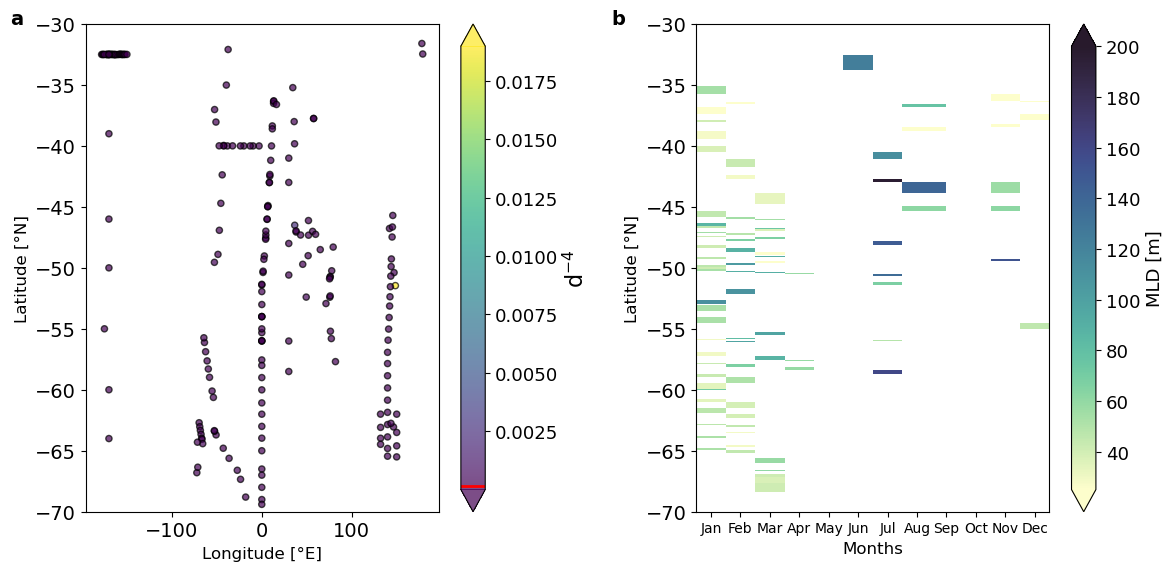

In [23]:
import textwrap
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
import cmocean

plt.rcParams['lines.linewidth'] = 2

# Read the Excel file with the MLD data
MLD_df = pd.read_excel('C:/Users/Thape/Downloads/Untitled Folder/Paper 2/MLD_IDP_cleaned.xlsx')
# Convert 'MLD_max_time' to datetime if not already
MLD_df['MLD_max_time'] = pd.to_datetime(MLD_df['MLD_max_time'], errors='coerce')

# Set 'MLD_max_time' as the index
MLD_df.set_index('MLD_max_time', inplace=True)

# Group by Latitude and Month, then take the mean over Longitude
data = MLD_df.groupby(['Latitude', 'Month']).mean()['MLD'].unstack()

# Define the figure size and grid layout (1 row, 2 columns)
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])  # Create a grid with 1 row and 2 columns

# -------------------- Left Plot ---------------------
# Calculate the mean of the scale factor
mean_scale_factor = MLD_df['scale_factor'].mean()

# Left plot: Scatter plot
ax0 = fig.add_subplot(gs[0, 0])  # First subplot
scatter = ax0.scatter(MLD_df['Longitude'], MLD_df['Latitude'], 
                      c=MLD_df['scale_factor'], cmap='viridis', 
                      s=20, edgecolor='k', alpha=0.7)

# Add a colorbar to the left plot
cbar = plt.colorbar(scatter, ax=ax0, label=r'$d^{-4}$', extend='both')

# Add a line on the colorbar to indicate the mean
cbar.ax.axhline(mean_scale_factor, color='red', linewidth=2)
#cbar.ax.legend(loc='center left', fontsize=10)
cbar.ax.tick_params(labelsize=13)
# Left plot labels
ax0.set_xlabel('Longitude [°E]', fontsize=12)
ax0.set_ylabel('Latitude [°N]', fontsize=12)
ax0.tick_params(axis='y', labelsize=14)
ax0.tick_params(axis='x', labelsize=14)

ax0.text(-280,-30, 'a',fontsize=14,fontweight='bold')

# -------------------- Right Plot ---------------------
# Right plot: pcolormesh
ax1 = fig.add_subplot(gs[0, 1])  # Second subplot
c = ax1.pcolormesh(data.columns, data.index, data.values, vmin=25, vmax=200, cmap=cmocean.cm.deep, shading='nearest')

# Add colorbar for the right plot
cbar = plt.colorbar(c, ax=ax1, orientation='vertical', extend='both')
cbar.set_label('MLD [m]', fontsize=13)
cbar.ax.tick_params(labelsize=13)  # Adjust fontsize for colorbar ticks

# Replace the x-axis index with month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax1.set_xticks(range(1, 13))  # Set the tick positions for the x-axis
ax1.set_xticklabels(month_names, fontsize=12)  # Set the labels for the x-axis
ax1.tick_params(axis='x', labelsize=10)  # Adjust font size for x-ticks
ax1.tick_params(axis='y', labelsize=14)
# Right plot labels
ax1.set_xlabel('Months', fontsize=12)
ax1.set_ylabel('Latitude [°N]', fontsize=12)

ax1.text(-2.4,-30, 'b',fontsize=14,fontweight='bold')

# Set the y-axis limits for both plots to be the same
#y_min, y_max = MLD_df['Latitude'].min(), MLD_df['Latitude'].max()
ax0.set_ylim(-70, -30)  # Left plot
ax1.set_ylim(-70, -30)  # Right plot



# Adjust layout
plt.tight_layout()

#plt.savefig('weighting2.png', bbox_inches='tight', dpi=499)

In [45]:
ds_MLD=ds.MLD_max.coarsen(Latitude=3, Longitude=3, boundary='trim').mean()

In [33]:
MLDMAXA=ds_MLD.sel(Longitude=slice(-70, 21)) 
MLDMAXI=ds_MLD.sel(Longitude=slice(21, 150))   
MLDMAXP=ds_MLD.sel(Longitude=slice(-70, 150))

# Plot manganocline, ferricline and MLDmax

C:\Users\Thape\AppData\Local\Temp\ipykernel_29268\3513168279.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


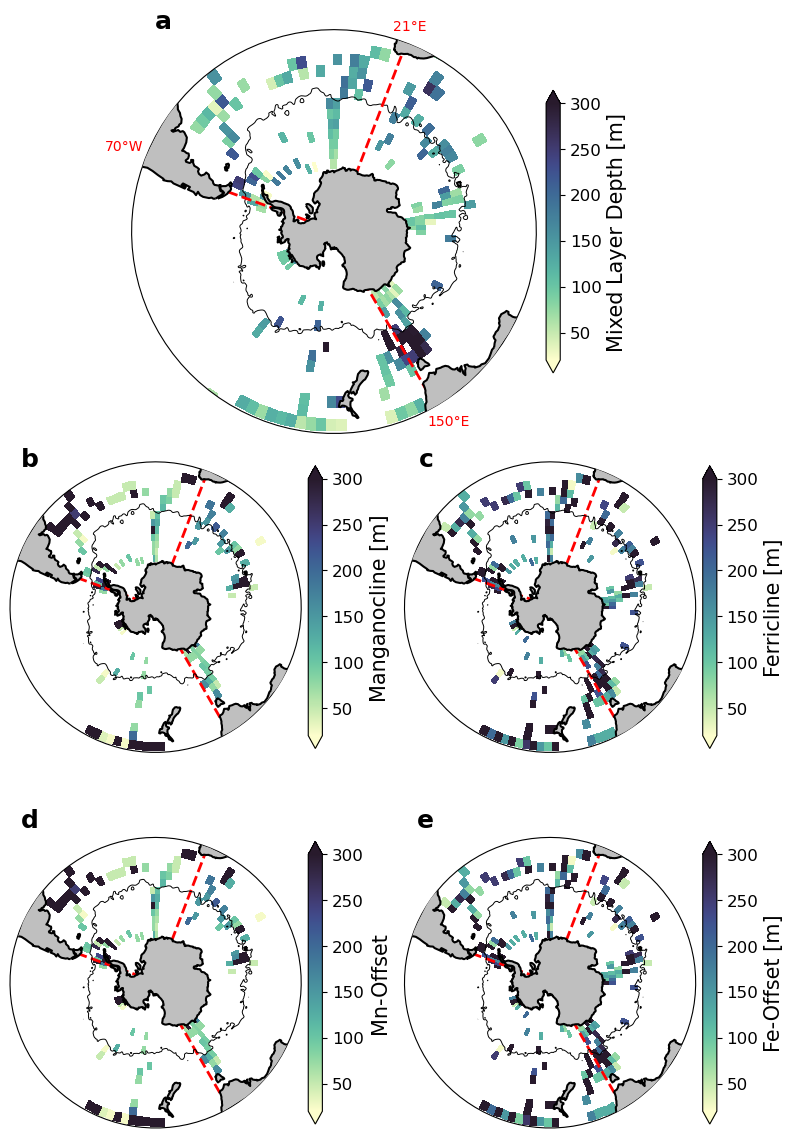

In [68]:
fig = plt.figure(figsize=(18, 15))  
gs = fig.add_gridspec(3, 3, width_ratios=[1.9, 1.1, 1.1], height_ratios=[1, 1, 1], wspace=0.1, hspace=-0.07)

projection = ccrs.SouthPolarStereo(central_longitude=0)
extent = [-180, 180, -90, -31]
transform = ccrs.RotatedPole(pole_longitude=180.0, pole_latitude=90.0, central_rotated_longitude=0.0)
land_feature = cartopy.feature.LAND
coastline_feature = cartopy.feature.COASTLINE
cmap = cmocean.cm.deep

# MLD 
ax = fig.add_subplot(gs[0, :], projection=projection)  
ax.add_feature(land_feature, facecolor='0.75', zorder=5)
ax.add_feature(coastline_feature, linewidth=1.5, zorder=5)
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)
ax.text(0.1, 1.05, 'a', transform=ax.transAxes, fontsize=18, fontweight='bold', va='top', ha='right')
contour = ax.contour(
        adt.longitude, adt.latitude, adt.adt, levels=[-0.48],
        linewidths=0.7, linestyles='-', colors='black', transform=ccrs.PlateCarree()
    )
# basin boundaries
ax.plot([-70, -70], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='red')  # Atlantic
ax.plot([21, 21], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='red')   # Indian
ax.plot([150, 150], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='red') # Pacific


# Label longitudes on basin boundaries
ax.text(-70, -26, '70°W', transform=ccrs.PlateCarree(), fontsize=10, ha='center', va='bottom', color='red')
ax.text(21, -29, '21°E', transform=ccrs.PlateCarree(), fontsize=10, ha='center', va='bottom', color='red')
ax.text(150, -25, '150°E', transform=ccrs.PlateCarree(), fontsize=10, ha='center', va='bottom', color='red')



# MLD
im = ds_MLD.plot(ax=ax, cmap=cmap, vmin=20, vmax=300, add_colorbar=False, transform=transform, extend='both')


cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.007, shrink=0.7, extend='both')
cbar.set_label("Mixed Layer Depth [m]", fontsize=15)
cbar.ax.tick_params(labelsize=12)

# Manganocline & Offset 
titles = ["Manganocline [m]", "Ferricline [m]"]
datasets = [ds_depth_at_max_grad,ds_depth_at_max_gradfe ]
labels = ['b', 'c']

for i in range(2):
    ax = fig.add_subplot(gs[1, i + 1], projection=projection)  
    ax.add_feature(land_feature, facecolor='0.75', zorder=5)
    ax.add_feature(coastline_feature, linewidth=1.5, zorder=5)
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.text(0.1, 1.05, labels[i], transform=ax.transAxes, fontsize=18, fontweight='bold', va='top', ha='right')

    # Basin boundaries
    ax.plot([-70, -70], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='red')
    ax.plot([21, 21], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='red')
    ax.plot([150, 150], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='red')

    # ADT contour
    contour = ax.contour(
        adt.longitude, adt.latitude, adt.adt, levels=[-0.48],
        linewidths=0.7, linestyles='-', colors='black', transform=ccrs.PlateCarree()
    )

    vmin, vmax = (-200, 200) if titles[i] == "Offset [m]" else (20, 300)
    
    im = datasets[i].plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=transform, extend='both')

    cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02, shrink=0.7, extend='both')
    cbar.set_label(titles[i], fontsize=15)
    cbar.ax.tick_params(labelsize=12)

#Ferricline & Offset
titles = ["Mn-Offset", "Fe-Offset [m]"] 
datasets = [ds_delta_mn, ds_delta_fe]
labels = ['d', 'e']

for i in range(2):
    ax = fig.add_subplot(gs[2, i + 1], projection=projection)  
    ax.add_feature(land_feature, facecolor='0.75', zorder=5)
    ax.add_feature(coastline_feature, linewidth=1.5, zorder=5)
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.text(0.1, 1.1, labels[i], transform=ax.transAxes, fontsize=18, fontweight='bold', va='top', ha='right')

    # Basin boundaries
    ax.plot([-70, -70], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='red')
    ax.plot([21, 21], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='red')
    ax.plot([150, 150], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='red')

    # ADT contour
    contour = ax.contour(
        adt.longitude, adt.latitude, adt.adt, levels=[-0.48],
        linewidths=0.7, linestyles='-', colors='black', transform=ccrs.PlateCarree()
    )

    vmin, vmax = (-200, 200) if titles[i] == "Offset [m]" else (20, 300)
    
    im = datasets[i].plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=transform, extend='both')

    cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02, shrink=0.7, extend='both')
    cbar.set_label(titles[i], fontsize=15)
    cbar.ax.tick_params(labelsize=12)


plt.tight_layout()



plt.savefig('Paper2_Figure1.png', bbox_inches='tight', dpi=499)


# DIAPYCNAL DIFFUSSION CALCULATION

In [348]:

Kz1 = 0.001
Kz2 = 0.0001
Kz3 = 0.00001

# Calculate diapycnal diffusion for each Kz
diapycnal_diffusion_1 = (Kz1 * ds_grad_mn3 * 31536000) / 1000
diapycnal_diffusion_2 = (Kz2 * ds_grad_mn3 * 31536000) / 1000
diapycnal_diffusion_3 = (Kz3 * ds_grad_mn3 * 31536000) / 1000
diapycnal_diffusion_mean = xr.concat(
    [diapycnal_diffusion_1, diapycnal_diffusion_2, diapycnal_diffusion_3], 
    dim="new_dim"
).mean(dim="new_dim")

diapycnal_diffusion_std = xr.concat(
    [diapycnal_diffusion_1, diapycnal_diffusion_2, diapycnal_diffusion_3], 
    dim="new_dim"
).std(dim="new_dim")





C:\Users\Thape\anaconda3\new ann\envs\tesha\Lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [349]:

Kz1 = 0.001
Kz2 = 0.0001
Kz3 = 0.00001
Kz_av=0.00037
# Calculate diapycnal diffusion for each Kz
diapycnal_diffusion_1 = (Kz1 * ds_grad_mn3 * 31536000) / 1000
diapycnal_diffusion_1 = (Kz2 * ds_grad_mn3 * 31536000) / 1000
diapycnal_diffusion_1 = (Kz3 * ds_grad_mn3 * 31536000) / 1000
diapycnal_diffusion_mean = xr.concat(
    [diapycnal_diffusion_1, diapycnal_diffusion_1], 
    dim="new_dim"
).mean(dim="new_dim")



In [350]:
Kz1 = 0.001
Kz2 = 0.0001
Kz3 = 0.00001
Kz_av=0.00037

diapycnal_diffusion_fe3 = (Kz3 * ds_grad_fe3 * 31536000) / 1000
diapycnal_diffusion_meanfe = xr.concat(
    [diapycnal_diffusion_fe3, diapycnal_diffusion_fe3], 
    dim="new_dim"
).mean(dim="new_dim")

diapycnal_diffusion_meanfe

<xarray.DataArray 'Fe' (Latitude: 16, Longitude: 120)> Size: 15kB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [ 0.1882342 ,  0.04558844,  0.44394888, ...,         nan,
                nan, -0.30750108],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
  * Latitude   (Latitude) float64 128B -75.0 -72.0 -69.0 ... -36.0 -33.0 -30.0
  * Longitude  (Longitude) float64 960B -179.0 -176.0 -173.0 ... 175.0 178.0

C:\Users\Thape\AppData\Local\Temp\ipykernel_8476\2444525218.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


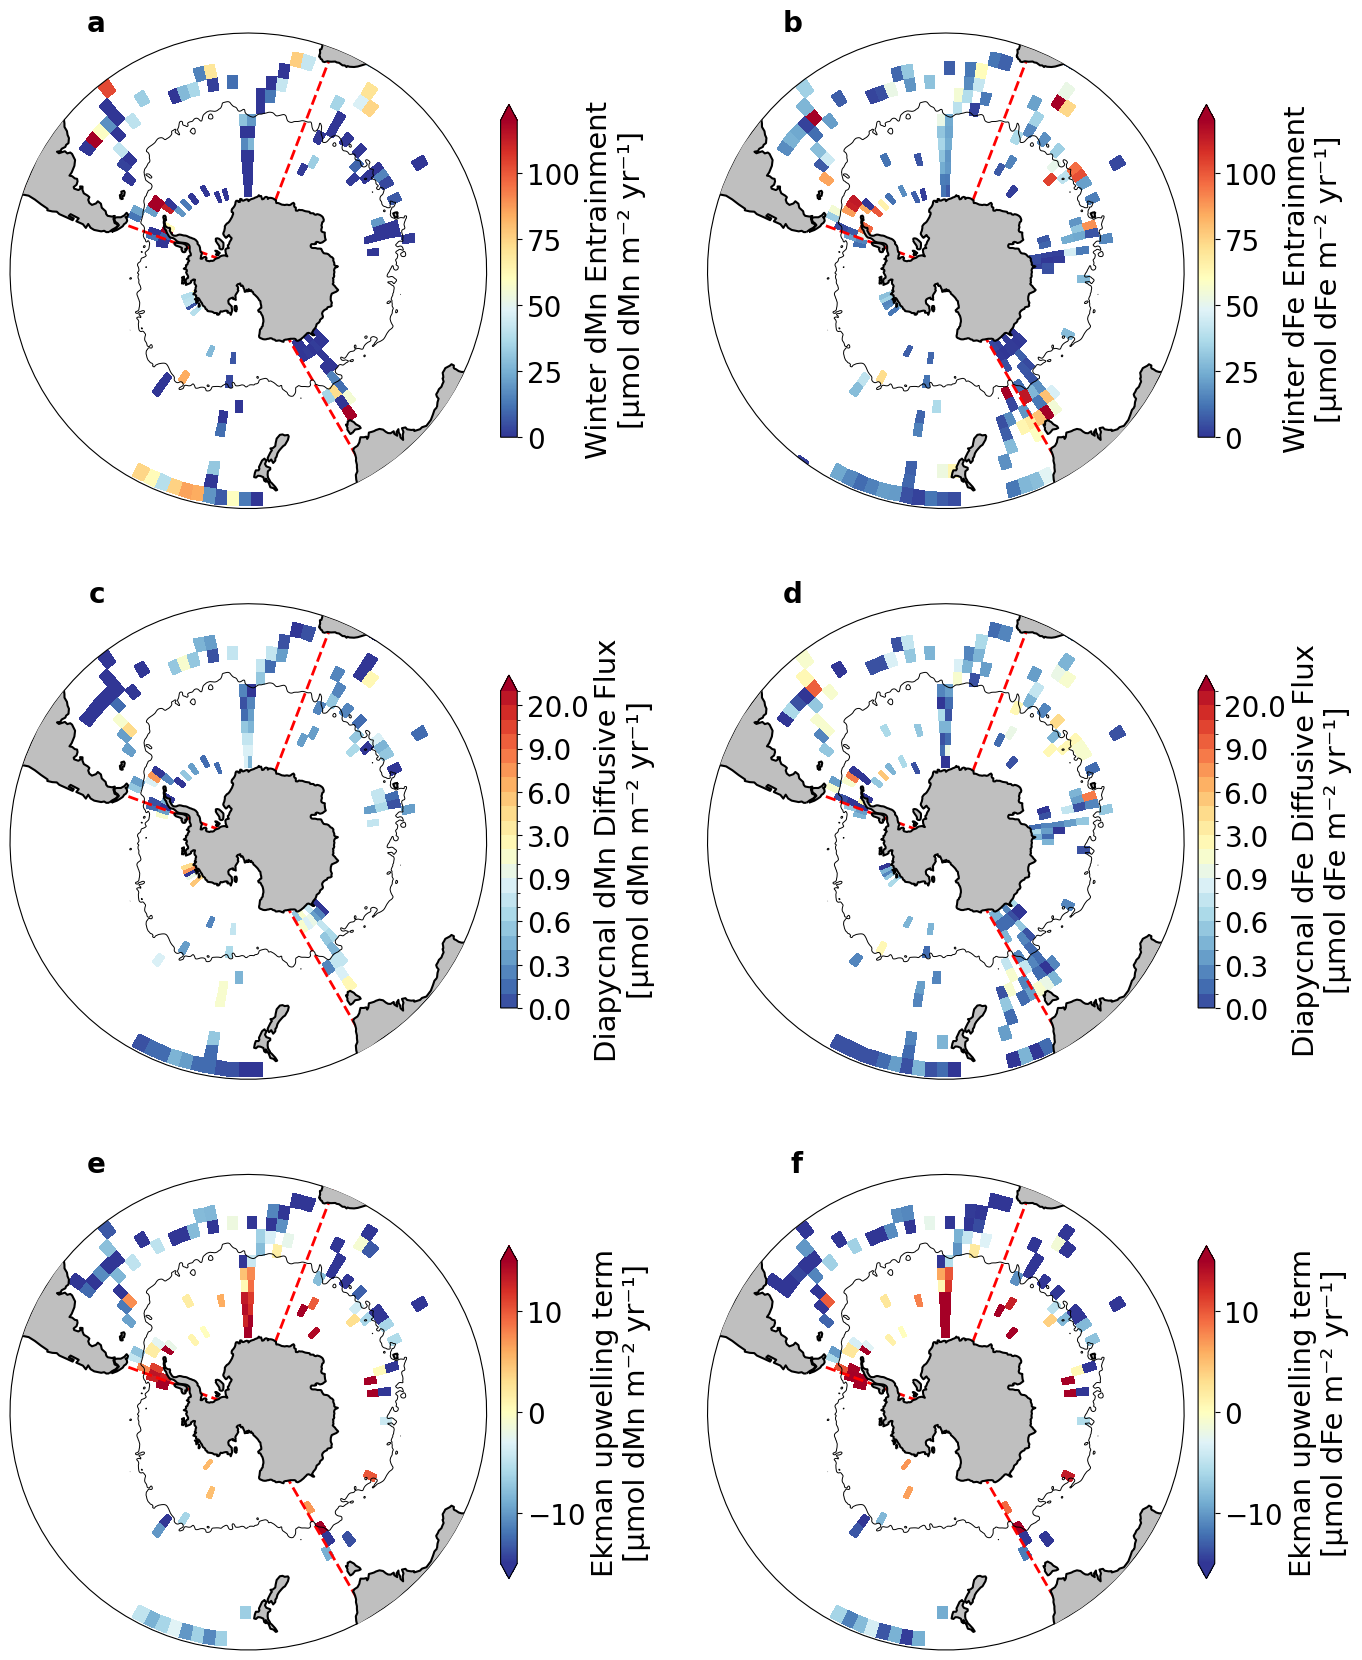

In [306]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Your existing setup for the figure and axes
fig = plt.figure(figsize=(18, 21))  # Adjusted for 3 rows × 2 columns
gs = fig.add_gridspec(3, 2, width_ratios=[1.5, 1.5], height_ratios=[1, 1, 1], wspace=0, hspace=0.2)

# Titles and datasets reordered to match new row structure
titles = [
    "Winter dMn Entrainment\n[µmol dMn m⁻² yr⁻¹]", "Winter dFe Entrainment\n[µmol dFe m⁻² yr⁻¹]",
    "Diapycnal dMn Diffusive Flux\n[µmol dMn m⁻² yr⁻¹]", "Diapycnal dFe Diffusive Flux\n[µmol dFe m⁻² yr⁻¹]",
    "Ekman upwelling term\n[µmol dMn m⁻² yr⁻¹]", "Ekman upwelling term\n[µmol dFe m⁻² yr⁻¹]"
]
datasets = [Entrainment, Entrainment_Fe, diapycnal_diffusion_mean, diapycnal_diffusion_meanfe, result, resultfe]
labels = ['a', 'b', 'c', 'd', 'e', 'f']

for i in range(6):
    row, col = divmod(i, 2)  # Map index to row and column positions (3 rows × 2 columns)
    ax = fig.add_subplot(gs[row, col], projection=projection)
    ax.add_feature(land_feature, facecolor='0.75', zorder=5)
    ax.add_feature(coastline_feature, linewidth=1.5, zorder=5)
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.text(0.2, 1.05, labels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
    ax.plot([-70, -70], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='red')  # Atlantic
    ax.plot([21, 21], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='red')   # Indian
    ax.plot([150, 150], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='red') # Pacific

    # Set color limits and normalization
    vmin, vmax = (0, 120) if row == 0 else (0, 25) if row == 1 else (-15, 15)
    norm = None
    if row == 1:  # Diapycnal diffusion plots
        # Define levels and use BoundaryNorm for smooth transitions within the plot
        levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25]
        norm = mcolors.BoundaryNorm(levels, ncolors=256, extend='both')

    # Plot the data with the specified norm
    im = datasets[i].plot(ax=ax, cmap='RdYlBu_r', vmin=vmin, vmax=vmax, add_colorbar=False,
                          transform=transform, norm=norm, extend='both')

    # Add contour only on the last two plots (i = 4, 5)
    if i in [0,1,2,3,4, 5]:
        contour_levels = [-0.48]
        ax.contour(
            adt.longitude,
            adt.latitude,
            adt.adt,
            levels=contour_levels,
            linewidths=0.7,
            linestyles='-',
            colors='black',
            transform=ccrs.PlateCarree()
        )

    # Add colorbar
    extend_opt = 'both' if i in [4, 5] else 'max'
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02, shrink=0.7, extend=extend_opt)
    cbar.set_label(titles[i], fontsize=21)
    
    

    # Smooth out the gridlines separating color levels in the colorbar (for second row plots)
    if row == 1:
        cbar.solids.set_edgecolor("none")  # Remove the color level separation lines

    cbar.ax.tick_params(labelsize=20)

plt.tight_layout()
plt.savefig('TOTAL.png', bbox_inches='tight', dpi=499)


In [308]:
# Replace NaN values in Detrainment with 0 before computing Entrainment
#detrainment_filled = ds.Detrainment.fillna(43)
detrainment_filled = ds.Detrainment.copy()

# Fill NaNs with the mean for each Latitude
detrainment_filled = detrainment_filled.groupby('Latitude').apply(lambda x: x.fillna(x.mean()))

# Fill NaNs with the mean for each Longitude
detrainment_filled = detrainment_filled.groupby('Longitude').apply(lambda x: x.fillna(x.mean()))

# Compute Entrainment with coarsening
Entrainment = (ds.Entrainment - Detrainment.mean()).coarsen(Latitude=3, Longitude=3, boundary='trim').mean()

Entrainment_Fe = (ds.EntrainmentFe-Detrainment_Fe.mean()).coarsen(Latitude=3, Longitude=3, boundary='trim').mean()

In [309]:
Entrainment = (ds.Entrainment-detrainment_filled).coarsen(Latitude=3, Longitude=3, boundary='trim').mean()

In [ ]:
adt

# Ekman Pumping

In [310]:

tau_file=xr.open_dataset('C:/Users/Thape/Downloads/wind_stress_2008_1deg.nc')

tau=tau_file.stress_curl
tau=tau.mean('time')#.coarsen(lat=3, lon=3, boundary='trim').mean()

In [311]:
# Mask values where Depth is greater than MLD_max
Mn_mean = ds['Mn'].where(ds['Depth'] <= ds['MLD_max']).mean(dim="Depth")
Fe_mean = ds['Fe'].where(ds['Depth'] <= ds['MLD_max']).mean(dim="Depth")
Mn_mean.min()

<xarray.DataArray 'Mn' ()> Size: 8B
array(0.03441484)

In [312]:
ds.Mn.mean()

<xarray.DataArray 'Mn' ()> Size: 8B
array(281075.24796108)

In [313]:
# Select Mn and Fe at MLD_max using nearest-neighbor interpolation
Mn_at_MLDmax = ds['Mn'].sel(Depth=ds['MLD_max'], method='nearest')
Fe_at_MLDmax = ds['Fe'].sel(Depth=ds['MLD_max'], method='nearest')

# Average over Month
Mn_at_MLDmax = Mn_at_MLDmax.mean('Month')
Fe_at_MLDmax = Fe_at_MLDmax.mean('Month')

# Ensure values are between 0 and 10
Mn = Mn_at_MLDmax.coarsen(Latitude=3, Longitude=3, boundary='trim').mean()
Fe = Fe_at_MLDmax.coarsen(Latitude=3, Longitude=3, boundary='trim').mean()

dens = density.mean(['Depth', 'Month']).coarsen(Latitude=3, Longitude=3, boundary='trim').mean()-1000
dens.max()

# EKMAN PUMPING CALCULATION

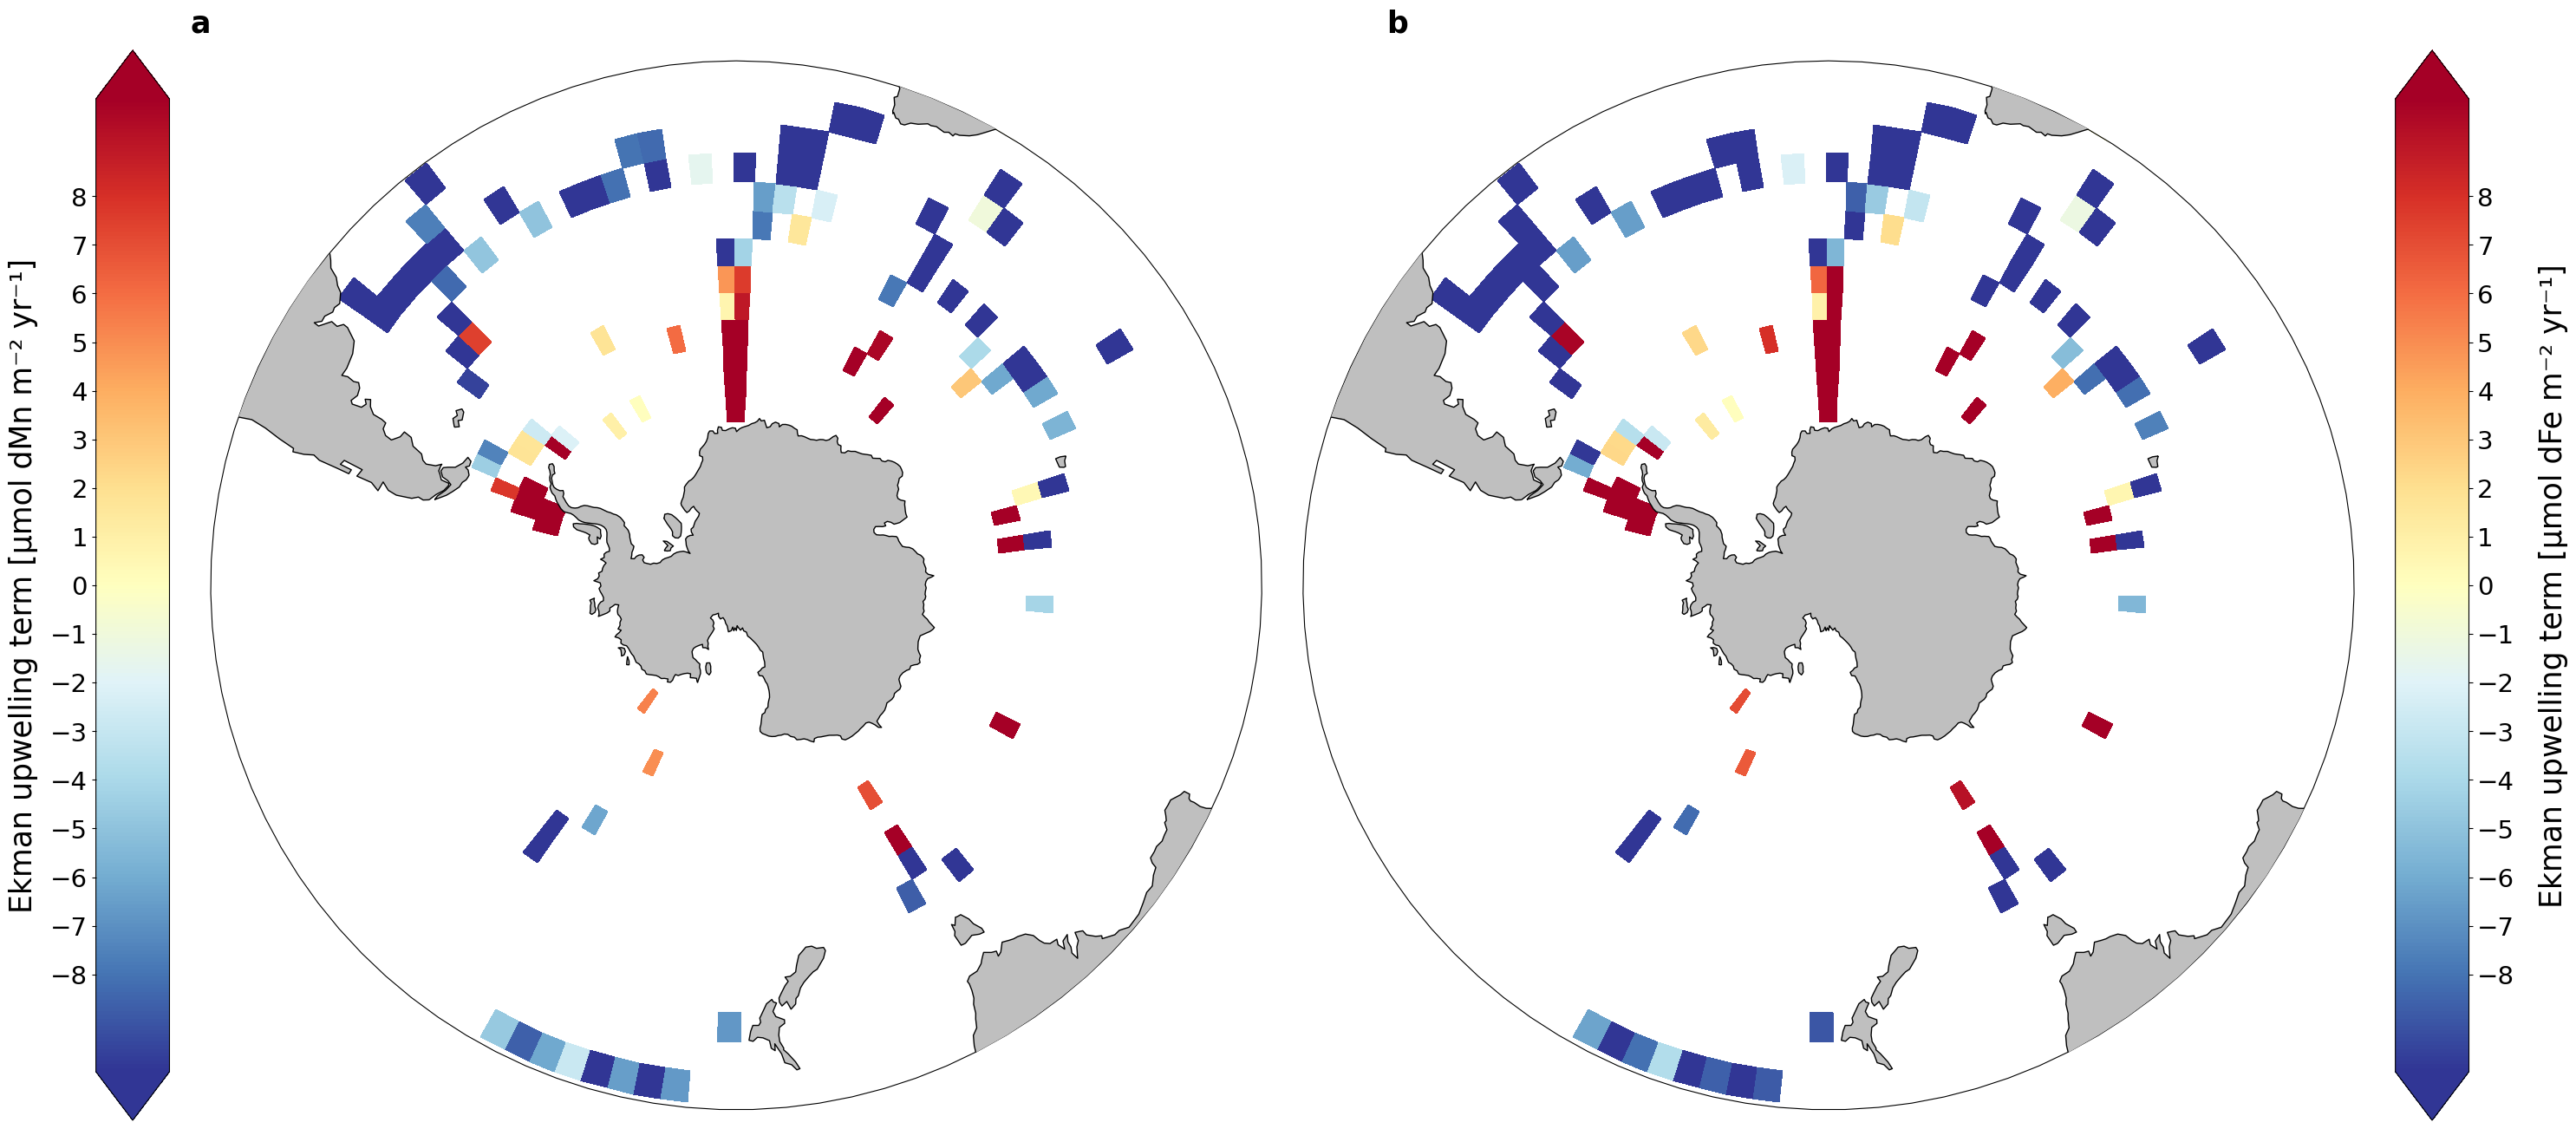

In [53]:
# Coarsen density field


# Coriolis parameter
f = (2 * 7.2921e-5) * np.sin(np.radians(ds.Latitude))


# Compute result using density and Coriolis parameter
result = (1 / (dens * f))* (tau.sel(lat=ds.Latitude, lon=ds.Longitude, method='nearest' ))*ds.Mn.mean()
resultfe =(1 / (dens* f)) * (tau.sel(lat=ds.Latitude, lon=ds.Longitude, method='nearest'))*-ds.Fe.mean()


#fig = plt.figure(figsize=(20, 9))
fig = plt.figure(figsize=(30, 13))
gs = fig.add_gridspec(1, 4, width_ratios=[0.07, 1, 1, 0.07]) 
ticks = np.arange(-8, 9, 1)
projection = ccrs.SouthPolarStereo(central_longitude=0)
extent = [-180, 180, -90, -31]
transform = ccrs.RotatedPole(pole_longitude=180.0, pole_latitude=90.0, central_rotated_longitude=0.0)
land_feature = cartopy.feature.LAND
coastline_feature = cartopy.feature.COASTLINE

vmin_mn, vmax_mn = 40, 120
ax0 = fig.add_subplot(gs[0, 1], projection=projection)
ax0.add_feature(land_feature, facecolor='0.75', zorder=5)
ax0.add_feature(coastline_feature, linewidth=1, zorder=5)
ax0.set_extent(extent, crs=ccrs.PlateCarree())
ax0.set_boundary(circle, transform=ax0.transAxes)

im_mn = result.plot(
    ax=ax0,vmin=-10,vmax=10, cmap='RdYlBu_r',
    add_colorbar=False, transform=transform,
    add_labels=False  # Suppress automatic titles/labels
)




cbar_mn_ax = fig.add_subplot(gs[0, 0])
cbar_mn = fig.colorbar(im_mn, cax=cbar_mn_ax, orientation='vertical', extend='both',ticks=ticks)
cbar_mn.set_label('Ekman upwelling term [µmol dMn m⁻² yr⁻¹]', labelpad=10,fontsize=25)
cbar_mn.ax.yaxis.set_ticks_position('left')
cbar_mn.ax.yaxis.set_label_position('left')
cbar_mn.ax.tick_params(labelsize=21)
ax0.text(0, 1.05, 'a', transform=ax0.transAxes, fontsize=25, fontweight='bold', va='top', ha='right')

vmin_fe, vmax_fe = 10, 60
ax1 = fig.add_subplot(gs[0, 2], projection=projection)
ax1.add_feature(land_feature, facecolor='0.75', zorder=5)
ax1.add_feature(coastline_feature, linewidth=1, zorder=5)
ax1.set_extent(extent, crs=ccrs.PlateCarree())
ax1.set_boundary(circle, transform=ax1.transAxes)

im_fe = resultfe.plot(
    ax=ax1,vmin=-10
    ,vmax=10,cmap='RdYlBu_r',
    add_colorbar=False, transform=transform,
    add_labels=False
)
cbar_fe_ax = fig.add_subplot(gs[0, 3])

cbar_fe = fig.colorbar(im_fe, cax=cbar_fe_ax, orientation='vertical', extend='both',ticks=ticks)
cbar_fe.set_label('Ekman upwelling term [µmol dFe m⁻² yr⁻¹]',labelpad=20,fontsize=25)


cbar_fe.ax.tick_params(labelsize=21)

ax1.text(0.1, 1.05, 'b', transform=ax1.transAxes, fontsize=25, fontweight='bold', va='top', ha='right')


plt.tight_layout()


# ADT

In [318]:
adtfile=xr.open_dataset("C:/Users/Thape/Downloads/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D_1737217969350.nc")
adt=adtfile.mean('time')

In [1]:
#diapycnal_diffusion_mean= diapycnal_diffusion_mean.where(diapycnal_diffusion_mean > 0, drop=True)
Flux=Entrainment+diapycnal_diffusion_mean+result+Detrainment
frac=(Entrainment/Flux)*100
frac=frac.mean()


NameError: name 'Entrainment' is not defined

In [363]:
#diapycnal_diffusion_meanfe = diapycnal_diffusion_meanfe.where(diapycnal_diffusion_meanfe > 0, drop=True)
Fluxfe=Entrainment_Fe+diapycnal_diffusion_meanfe+resultfe#-Detrainment_Fe
frac=(diapycnal_diffusion_meanfe/Fluxfe)*100
frac=frac.mean()
frac

<xarray.DataArray ()> Size: 8B
array(1.2987322)

In [364]:

Flux = xr.where(
    np.isnan(Entrainment) & np.isnan(diapycnal_diffusion_mean) & np.isnan(result), 
    np.nan,  # If all are NaN, keep it NaN
    np.nan_to_num(Entrainment, nan=0) + 
    np.nan_to_num(diapycnal_diffusion_mean, nan=0) + 
    np.nan_to_num(result, nan=0)
)



In [365]:

FluxFe = xr.where(
    np.isnan(Entrainment_Fe) & np.isnan(diapycnal_diffusion_meanfe) & np.isnan(resultfe), 
    np.nan,  # If all are NaN, keep it NaN
    np.nan_to_num(Entrainment_Fe, nan=0) + 
    np.nan_to_num(diapycnal_diffusion_meanfe, nan=0) + 
    np.nan_to_num(resultfe, nan=0)
)

In [370]:
ratio=Flux/FluxFe

# Plot total dMn/Total dFe

C:\Users\Thape\AppData\Local\Temp\ipykernel_8476\3097754348.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


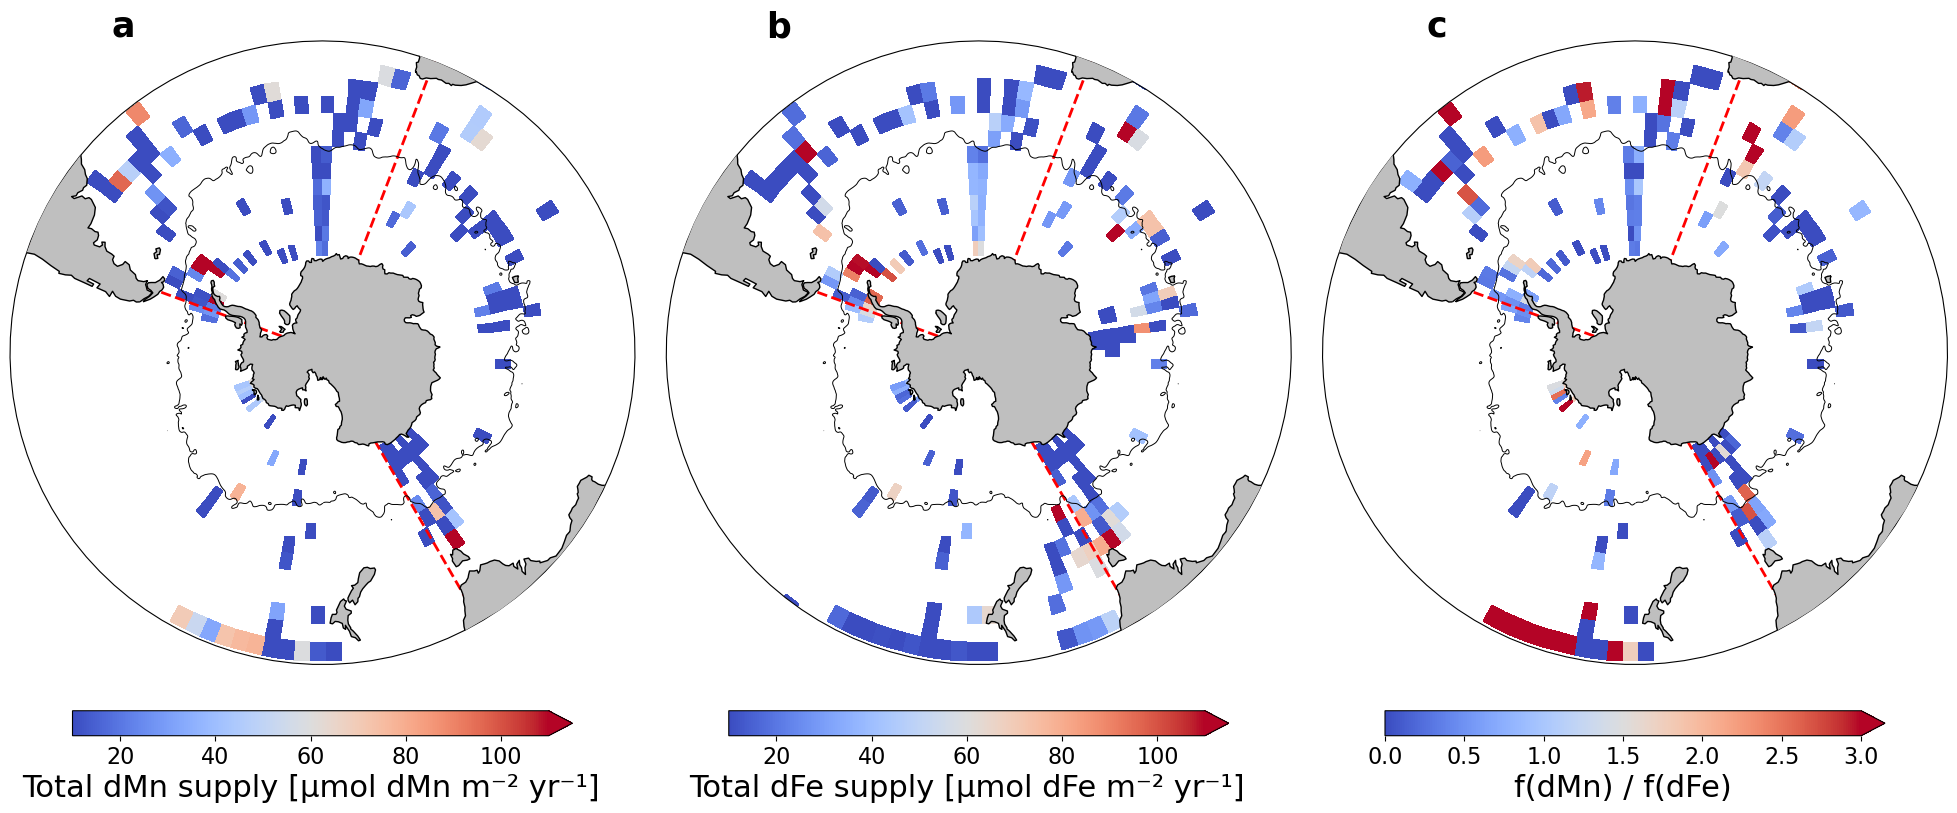

In [374]:
fig = plt.figure(figsize=(25, 12))  # Slightly reduced size for better proportions
gs = fig.add_gridspec(1, 3, width_ratios=[1.5, 1.5, 1.5], wspace=0.05)  # Add spacing between subplots

projection = ccrs.SouthPolarStereo(central_longitude=0)
extent = [-180, 180, -90, -31]
transform = ccrs.RotatedPole(pole_longitude=180.0, pole_latitude=90.0, central_rotated_longitude=0.0)
land_feature = cartopy.feature.LAND
coastline_feature = cartopy.feature.COASTLINE

ax0 = fig.add_subplot(gs[0, 0], projection=projection)
ax0.add_feature(land_feature, facecolor='0.75', zorder=5)
ax0.add_feature(coastline_feature, linewidth=1, zorder=5)
ax0.set_extent(extent, crs=ccrs.PlateCarree())
ax0.set_boundary(circle, transform=ax0.transAxes)
ax0.text(0.2, 1.05, 'a', transform=ax0.transAxes, fontweight='bold',fontsize=25, va='top', ha='right')
# Basin boundaries
ax0.plot([-70, -70], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='red', linewidth=2)
ax0.plot([21, 21], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='red', linewidth=2)
ax0.plot([150, 150], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='red', linewidth=2)
contour = ax0.contour(
        adt.longitude, adt.latitude, adt.adt, levels=[-0.48],
        linewidths=0.7, linestyles='-', colors='black', transform=ccrs.PlateCarree()
    )
im_mn = Flux.plot(
    ax=ax0, vmin=10, vmax=110, cmap='coolwarm',
    add_colorbar=False, transform=transform
)

cbar_mn = fig.colorbar(im_mn, ax=ax0, orientation='horizontal', pad=0.05, shrink=0.8, extend='max')
cbar_mn.set_label('Total dMn supply [µmol dMn m⁻² yr⁻¹]', fontsize=22)

# Mixed Layer Depth Plot
ax1 = fig.add_subplot(gs[0, 1], projection=projection)
ax1.add_feature(land_feature, facecolor='0.75', zorder=5)
ax1.add_feature(coastline_feature, linewidth=1, zorder=5)
ax1.set_extent(extent, crs=ccrs.PlateCarree())
ax1.set_boundary(circle, transform=ax1.transAxes)
ax1.text(0.2, 1.05, 'b', transform=ax1.transAxes, fontweight='bold',fontsize=25, va='top', ha='right')
# Basin boundaries
ax1.plot([-70, -70], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='red', linewidth=2)
ax1.plot([21, 21], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='red', linewidth=2)
ax1.plot([150, 150], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='red', linewidth=2)

contour = ax1.contour(
        adt.longitude, adt.latitude, adt.adt, levels=[-0.48],
        linewidths=0.7, linestyles='-', colors='black', transform=ccrs.PlateCarree()
    )


im_fe = FluxFe.plot(
    ax=ax1,vmin=10, vmax=110,cmap='coolwarm',
    add_colorbar=False, transform=transform)

cbar_fe = fig.colorbar(im_fe, ax=ax1, orientation='horizontal', pad=0.05, shrink=0.8, extend='max')
cbar_fe.set_label('Total dFe supply [µmol dFe m⁻² yr⁻¹]', fontsize=22)

# Delta Plot
ax2 = fig.add_subplot(gs[0, 2], projection=projection)
ax2.add_feature(land_feature, facecolor='0.75', zorder=5)
ax2.add_feature(coastline_feature, linewidth=1, zorder=5)
ax2.set_extent(extent, crs=ccrs.PlateCarree())
ax2.set_boundary(circle, transform=ax2.transAxes)
ax2.text(0.2, 1.05, 'c', transform=ax2.transAxes, fontweight='bold',fontsize=25, va='top', ha='right')
# Basin boundaries
ax2.plot([-70, -70], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='red', linewidth=2)
ax2.plot([21, 21], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='red', linewidth=2)
ax2.plot([150, 150], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='red', linewidth=2)

contour = ax2.contour(
        adt.longitude, adt.latitude, adt.adt, levels=[-0.48],
        linewidths=0.7, linestyles='-', colors='black', transform=ccrs.PlateCarree()
    )
im_delta = ratio.plot(
    ax=ax2, cmap='coolwarm', vmin=0,vmax=3,
    add_colorbar=False, transform=transform, extend='max'
)
cbar_delta = fig.colorbar(im_delta, ax=ax2, orientation='horizontal', pad=0.05, shrink=0.8, extend='max')
cbar_delta.set_label("f(dMn) / f(dFe)", fontsize=22)

ax0.set_title('')  # Removes the title on the first plot
ax1.set_title('')  # Removes the title on the second plot
ax2.set_title('')  # Removes the title on the first plot


plt.tight_layout()
plt.savefig('Supply ratio.png', bbox_inches='tight', dpi=499)

# VERTICAL PROFILES

In [82]:
# Convert MLD (m) to the nearest Depth index
MLD_index = ds.Depth.searchsorted(ds.MLD)

# Mask values below MLD for Mn and Fe
Mn_in_MLD = ds.Mn.where(ds.Depth <= ds.MLD, drop=True)
Fe_in_MLD = ds.Fe.where(ds.Depth <= ds.MLD, drop=True)

# Compute the mean Mn and Fe concentration in the MLD for each (Latitude, Longitude, Month)
Mn_MLD_avg = Mn_in_MLD.mean(dim="Depth")
Fe_MLD_avg = Fe_in_MLD.mean(dim="Depth")

# Check results

Fe_MLD_avg.mean()


<xarray.DataArray 'Fe' ()> Size: 8B
array(0.1784412)

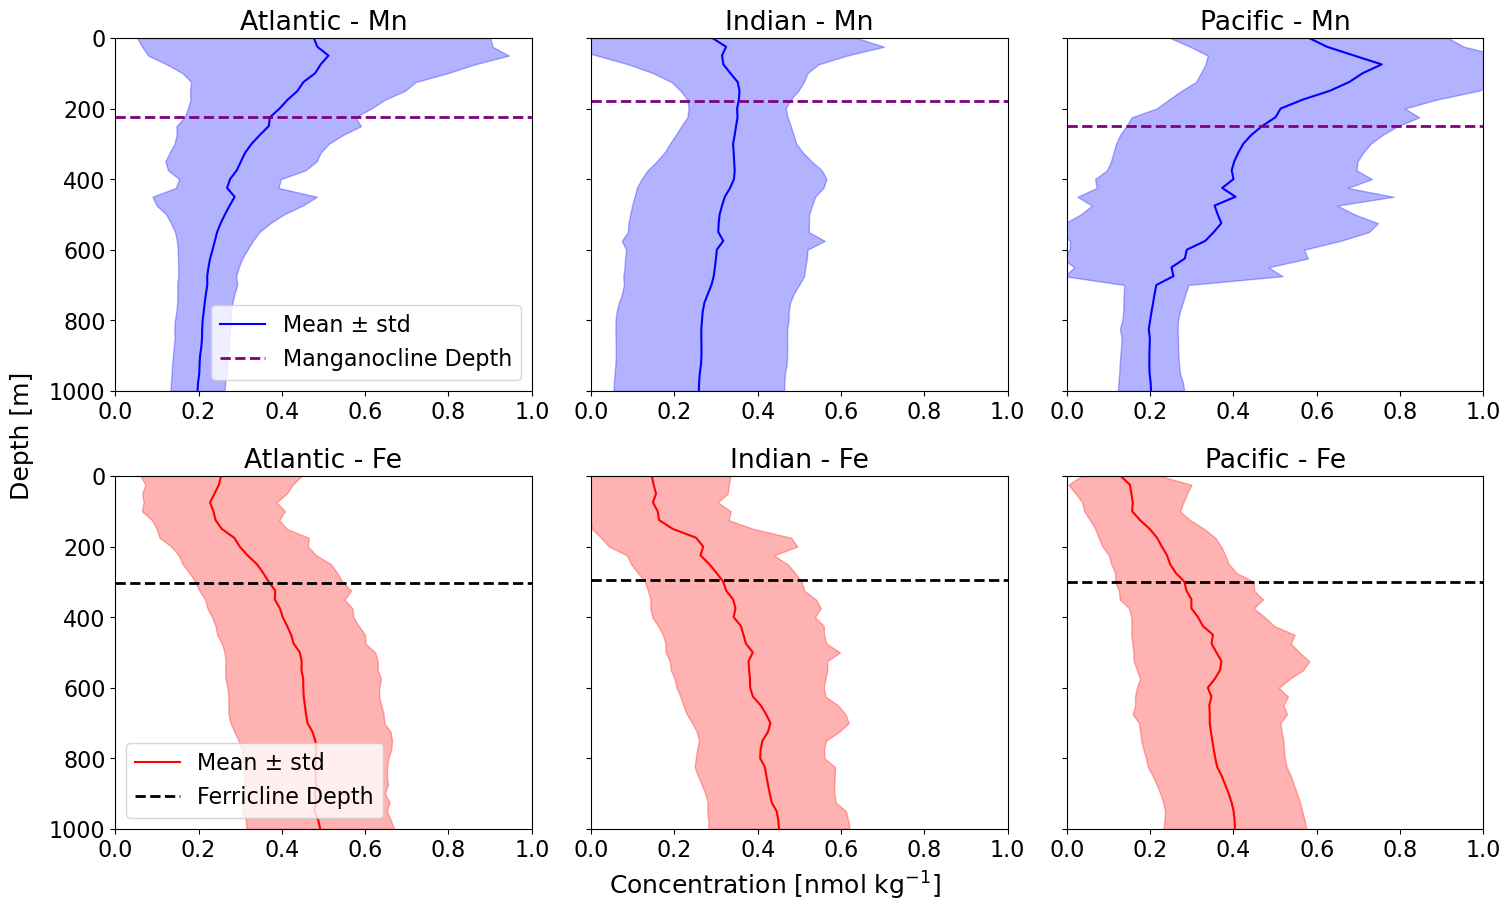

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 9), sharey=True)

# Define ocean basins based on longitude
atlantic = (ds.Longitude >= -70) & (ds.Longitude <= 20)
indian = (ds.Longitude > 20) & (ds.Longitude <= 146)
pacific = ~atlantic & ~indian  # Remaining longitudes

# Keep Mn and Fe within the range 0-5
ds_filtered = ds.where((ds.Mn >= 0) & (ds.Mn <= 2) & (ds.Fe >= 0) & (ds.Fe <= 1), drop=True)

# Define function to compute mean, mean ± std for a given variable and mask
def plot_variable(ax, var, mask, color, plot_manganocline=False, plot_ferricline=False, legend_pos=None):
    mean = ds_filtered[var].where(mask).mean(dim=["Latitude", "Longitude", "Month"])
    std = ds_filtered[var].where(mask).std(dim=["Latitude", "Longitude", "Month"])
    
    ax.plot(mean, ds.Depth, label="Mean ± std", color=color)
    ax.fill_betweenx(ds.Depth, mean - std, mean + std, color=color, alpha=0.3)
    ax.invert_yaxis()  # Invert y-axis so depth increases downward
    ax.set_ylim(0, 1000)  # Adjust depth range

    # Plot manganocline (top row - Mn)
    if plot_manganocline:
        manganocline_depth = ds_depth_at_max_grad.where(mask).mean().values
        ax.axhline(y=manganocline_depth, color="purple", linestyle="--", linewidth=2, label="Manganocline Depth")

    # Plot ferricline (bottom row - Fe)
    if plot_ferricline:
        ferricline_depth = ds_depth_at_max_gradfe.where(mask).mean().values
        ax.axhline(y=ferricline_depth, color="black", linestyle="--", linewidth=2, label="Ferricline Depth")

    # Only show legend in specific plots with defined positions
    if legend_pos:
        ax.legend(loc=legend_pos)

# Define variable names and subplot titles
variables = ["Mn", "Fe"]
titles = ["Atlantic", "Indian", "Pacific"]
colors = ["blue", "red"]

# Iterate over basins and variables
for col, (basin, title) in enumerate(zip([atlantic, indian, pacific], titles)):
    for row, (var, color) in enumerate(zip(variables, colors)):
        ax = axes[row, col]
        plot_manganocline = (var == "Mn")  # Only plot manganocline for Mn (top row)
        plot_ferricline = (var == "Fe")  # Only plot ferricline for Fe (bottom row)

        # Define legend positions: 
        # - Top-left Mn (Atlantic) → Bottom-right
        # - Bottom-middle Fe (Indian) → Bottom-left
        legend_pos = None
        if row == 0 and col == 0:
            legend_pos = "lower right"
        elif row == 1 and col == 0:
            legend_pos = "lower left"

        plot_variable(ax, var, basin, color, 
                      plot_manganocline=plot_manganocline, 
                      plot_ferricline=plot_ferricline, 
                      legend_pos=legend_pos)
        
        ax.set_title(f"{title} - {var}")
        ax.set_ylim(1000, 0)
        ax.set_xlim(0, 1)

# Set shared axis labels
fig.text(0.5, -0.01, "Concentration [nmol kg$^{-1}$]", ha="center", fontsize=18)
fig.text(-0.01, 0.5, "Depth [m]", va="center", rotation="vertical", fontsize=18)

plt.tight_layout()
plt.savefig('Profiles.png', bbox_inches='tight', dpi=499)



In [8]:
# Given slopes for North and South
slope_north = 3.969
slope_south = 2.5433

# Calculate Mn* for North and South using the formula Mn* = Mn - (Fe / slope)
Mn_star_north = Mn_north - (Fe_north / slope_north)
Mn_star_south = Mn_south - (Fe_south / slope_south)

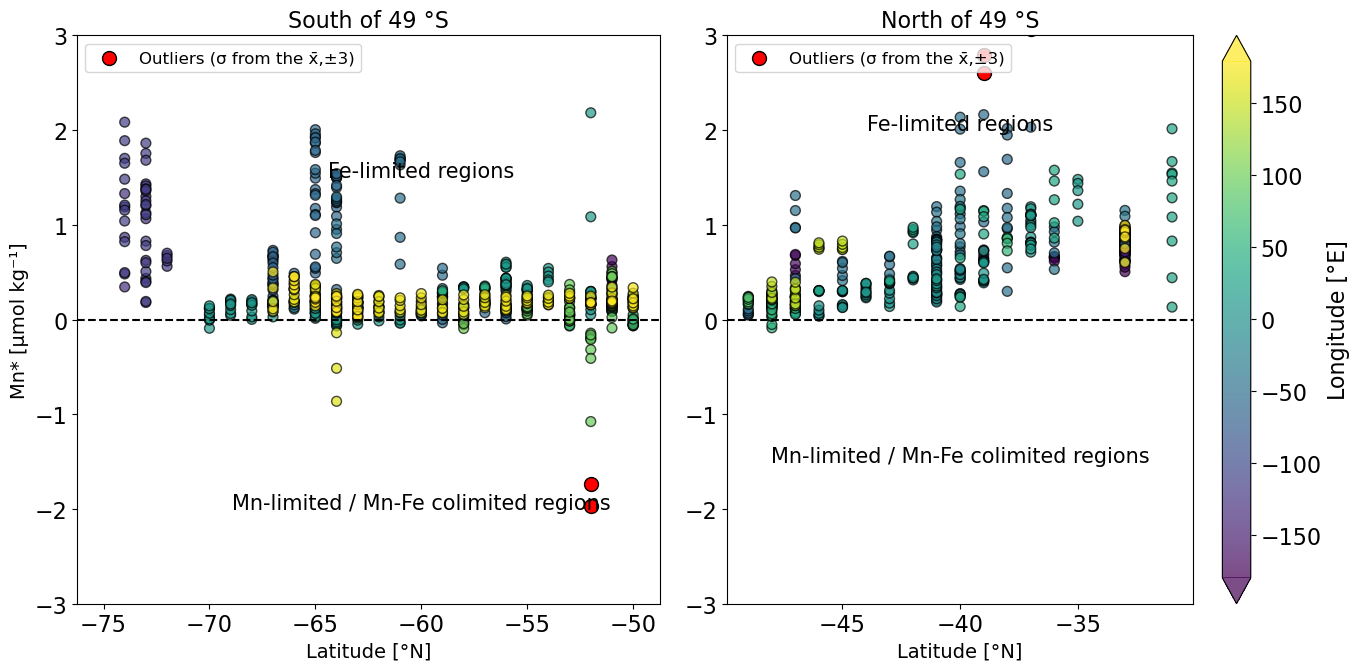

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Assuming latitudes, longitudes, Mn_star_north, Mn_star_south are already defined

# Calculate the Z-scores for Mn_star_north and Mn_star_south
z_scores_north = zscore(Mn_star_north)
z_scores_south = zscore(Mn_star_south)

# Set a threshold for detecting outliers (e.g., z-score > 3 or z-score < -3)
threshold = 3

# Find outliers
outliers_north = np.abs(z_scores_north) > threshold
outliers_south = np.abs(z_scores_south) > threshold

# Plot Mn* vs Latitude for North and South regions with color based on Longitude

plt.figure(figsize=(14, 7))

# North subplot: Mn* vs Latitude with color based on Longitude
ax1 = plt.subplot(122)
scatter1 = ax1.scatter(latitudes[north_mask], Mn_star_north, c=longitudes[north_mask], cmap='viridis', s=50, alpha=0.7, edgecolor='k')
ax1.set_xlabel('Latitude [°N]', fontsize=14)
ax1.set_title('North of 49 °S', fontsize=16)
ax1.set_ylim(-3, 3)
# Set x-axis ticks to increments of 5
ax1.set_xticks(range(-50, -30 + 1, 5))

# Add a horizontal dashed line at y = 0
ax1.axhline(0, color='black', linestyle='--')

# Annotate above zero line (Fe-limited sites)
ax1.text(-40, 2, 'Fe-limited regions', color='black', fontsize=15, ha='center')

# Annotate below zero line (Mn-limited or Mn-Fe colimited regions)
ax1.text(-40, -1.5, 'Mn-limited / Mn-Fe colimited regions', color='black', fontsize=15, ha='center')

# Add a colorbar for the scatter plot
plt.colorbar(scatter1, label='Longitude [°E]', ax=ax1, extend='both')

# Highlight outliers in North region
ax1.scatter(latitudes[north_mask][outliers_north], Mn_star_north[outliers_north], color='red', s=100, label='Outliers (σ from the x̄,±3)', edgecolor='black')

# South subplot: Mn* vs Latitude with color based on Longitude
ax2 = plt.subplot(121)
scatter2 = ax2.scatter(latitudes[south_mask], Mn_star_south, c=longitudes[south_mask], cmap='viridis', s=50, alpha=0.7, edgecolor='k')
ax2.set_xlabel('Latitude [°N]', fontsize=14)
ax2.set_ylabel('Mn* [µmol kg⁻¹]', fontsize=14)
ax2.set_title('South of 49 °S', fontsize=16)
ax2.set_ylim(-3, 3)

# Add a horizontal dashed line at y = 0
ax2.axhline(0, color='black', linestyle='--')

# Annotate above zero line (Fe-limited sites)
ax2.text(-60, 1.5, 'Fe-limited regions', color='black', fontsize=15, ha='center')

# Annotate below zero line (Mn-limited or Mn-Fe colimited regions)
ax2.text(-60, -2, 'Mn-limited / Mn-Fe colimited regions', color='black', fontsize=15, ha='center')

# Highlight outliers in South region
ax2.scatter(latitudes[south_mask][outliers_south], Mn_star_south[outliers_south], color='red', s=100, label='Outliers (σ from the x̄,±3)', edgecolor='black')

# Add legend for outliers
ax1.legend(loc='upper left', fontsize=12)
ax2.legend(loc='upper left', fontsize=12)

# Layout adjustments
plt.tight_layout()
#plt.savefig('Figure8.png', bbox_inches='tight', dpi=499)


In [10]:
ds_top_200m = ds.sel(Depth=slice(0, 100))

# Stack the data to retain individual entries
stacked_data = ds_top_200m.stack(points=("Latitude", "Longitude", "Depth", "Month"))
Fe_values = stacked_data.Fe.values
Mn_values = stacked_data.Mn.values
latitudes = stacked_data["Latitude"].values
longitudes = stacked_data["Longitude"].values
# Remove NaN values to ensure clean data
valid_mask = ~np.isnan(Fe_values) & ~np.isnan(Mn_values)
Fe_values = Fe_values[valid_mask]
Mn_values = Mn_values[valid_mask]
latitudes = latitudes[valid_mask]
longitudes= longitudes[valid_mask]
# Separate data into north and south of -49.1335875
north_mask = latitudes > -49.1335875
south_mask = latitudes <= -49.1335875

Fe_north = Fe_values[north_mask]
Mn_north = Mn_values[north_mask]

Fe_south = Fe_values[south_mask]
Mn_south = Mn_values[south_mask]


data=ds_top_200m.mean('Month')
data=data.mean('Depth')

C:\Users\Thape\AppData\Local\Temp\ipykernel_10068\482673401.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


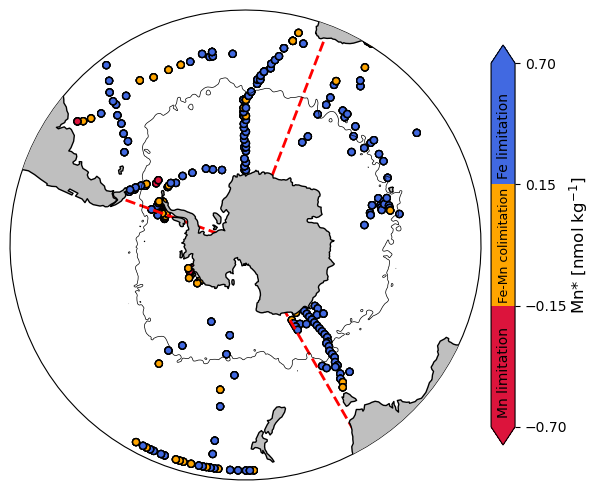

In [11]:
import numpy as np

# Given slopes for North and South
slope_north = 3.9690
slope_south = 2.5433

# Ensure Mn and Fe values are between 0 and 4 using np.clip
Mn_north = np.clip(Mn_north, 0, 2.5)
Fe_north = np.clip(Fe_north, 0, 2.5)
Mn_south = np.clip(Mn_south, 0, 2.5)
Fe_south = np.clip(Fe_south, 0,2.5)

# Calculate Mn* for North and South
Mn_star_north = Mn_north - (Fe_north / slope_north)
Mn_star_south = Mn_south - (Fe_south / slope_south)


fig = plt.figure(figsize=(8, 5))
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 3
import cmocean as cmo
gs = fig.add_gridspec(1, 2, width_ratios=[1,0.05])

projection = ccrs.SouthPolarStereo(central_longitude=0)
extent = [-180, 180, -90, -31]
transform = ccrs.RotatedPole(pole_longitude=180.0, pole_latitude=90.0, central_rotated_longitude=0.0)
land_feature = cartopy.feature.LAND
coastline_feature = cartopy.feature.COASTLINE


ax0 = fig.add_subplot(gs[0, 0], projection=projection)
ax0.add_feature(land_feature, facecolor='0.75', zorder=5)
ax0.add_feature(coastline_feature, linewidth=1, zorder=5)
ax0.set_extent(extent, crs=ccrs.PlateCarree())
ax0.set_boundary(circle, transform=ax0.transAxes)



cmapPMF =  ListedColormap([  'royalblue','orange','crimson' ])

cFe_south = ax0.scatter(
    longitudes[south_mask], 
    latitudes[south_mask], 
    c=Mn_star_south, 
    cmap=cmapPMF, 
    s=25, 
    edgecolor='k', 
    alpha=1,
    transform=ccrs.PlateCarree()
)

# Scatter plot for the north
cFe_north = ax0.scatter(
    longitudes[north_mask], 
    latitudes[north_mask], 
    c=Mn_star_north, 
    cmap=cmapPMF, 
    s=25, 
    edgecolor='k', 
    alpha=1,
    transform=ccrs.PlateCarree()
)


# Basin boundaries
ax0.plot([-70, -70], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='red', linewidth=2)
ax0.plot([21, 21], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='red', linewidth=2)
ax0.plot([150, 150], [-90, -31], transform=ccrs.PlateCarree(), linestyle='dashed', color='red', linewidth=2)


# Add ADT frontal lines
levels = [-0.48]
contour = ax0.contour(
    adt.longitude,  # or the appropriate coordinate name
    adt.latitude,   # or the appropriate coordinate name
    adt.adt,    # the DataArray
    levels=levels,
    linewidths=0.5,
    linestyles='-',
    colors='black',
    transform=ccrs.PlateCarree()
)

custom_cmap = ListedColormap(['crimson','orange','royalblue'])

# Define boundaries for the color segments
boundaries = [-0.7, -0.15,0.15, 0.7]
norm = mcolors.BoundaryNorm(boundaries, custom_cmap.N)
# Define the normalization for the colorbar
#norm = Normalize(vmin=-0.5, vmax=0.5)

# Add the colorbar
colorbar_ax = fig.add_axes([0.82
                            , 0.1, 0.03, 0.8])  # Position for the colorbar [left, bottom, width, height]
colorbar = ColorbarBase(colorbar_ax, cmap=custom_cmap, norm=norm, orientation='vertical',extend='both')

# Add label to the colorbar
colorbar.set_label("Mn* [nmol kg$^{-1}$]", fontsize=12, labelpad=0.001)

colorbar.ax.text(
    0.55, 0.5, "Fe-Mn colimitation", 
    va='center', ha='center', rotation=90, 
    fontsize=9, transform=colorbar.ax.transAxes
)

colorbar.ax.text(
    0.55, 0.8, "Fe limitation", 
    va='center', ha='center', rotation=90, 
    fontsize=10, transform=colorbar.ax.transAxes
)

colorbar.ax.text(
    0.55, 0.15, "Mn limitation", 
    va='center', ha='center', rotation=90, 
    fontsize=10, transform=colorbar.ax.transAxes
)



#fig.suptitle('Net Primary Production colormap')

plt.tight_layout()

#plt.savefig('Mn_Star.png', bbox_inches='tight', dpi=499)


# Calculating MLD from CTD Sensor Data

In [22]:
fname = 'C:/Users/Thape/Downloads/Untitled Folder/Paper 2/IDP2021_GEOTRACES_IDP2021_Seawater_Sensor_Data_v1_2WCU6WVF/IDP2021_GEOTRACES_IDP2021_Seawater_Sensor_Data_v1_2WCU6WVF.txt'
ctd = pd.read_csv(fname, delimiter='\t', skiprows=37, on_bad_lines='skip', engine='python', parse_dates=['yyyy-mm-ddThh:mm:ss.sss'])
fname2 = 'C:/Users/Thape/Downloads/Untitled Folder/Copy of AGU060 Profile Data Calibrated.xlsx'
df = pd.read_excel(fname2)

ctd = ctd[['Cruise', 'Station', 'Type', 'yyyy-mm-ddThh:mm:ss.sss',
       'Longitude [degrees_east]', 'Latitude [degrees_north]',
       'CTDPRS_T_VALUE_SENSOR [dbar]',
       'CTDTMP_T_VALUE_SENSOR [deg C]', 
       'CTDSAL_D_CONC_SENSOR [pss-78]',
       'CTDOXY_D_CONC_SENSOR [umol/kg]', 
       'CTDCHLA_T_CONC_SENSOR [mg/m^3]', 
       'CTDFLUOR_T_VALUE_SENSOR [arbitrary units]',
       'CTDBEAMCP_T_VALUE_SENSOR [1/m]',
       'CTDXMISS_T_VALUE_SENSOR [arbitrary units]', 
       'CTDTURB_T_VALUE_SENSOR [arbitrary units]',
       'CTDPAR_T_VALUE_SENSOR [arbitrary units]']]

ctd.columns = ['Cruise', 'Station', 'Type', 'Datetime',
       'Longitude', 'Latitude',
       'Pressure',
       'Temp', 'Psal',
       'Oxy', 'Chla',
       'Fluor',
       'Cp',
       'Ct',
       'Turb',
       'Par']

ctd['Psal_Absolute']  = gsw.SA_from_SP(ctd.Psal, ctd.Pressure, ctd.Longitude, ctd.Latitude)
ctd['Density'] = gsw.pot_rho_t_exact(ctd.Psal_Absolute, ctd.Temp, ctd.Pressure, 0)

df['Psal_Absolute']  = gsw.SA_from_SP(ctd.Psal, ctd.Pressure, ctd.Longitude, ctd.Latitude)
df['Density'] = gsw.pot_rho_t_exact(ctd.Psal_Absolute, ctd.Temp, ctd.Pressure, 0)
dfcont = pd.concat([ctd,df])

In [23]:

fname3 = 'C:/Users/Thape/Downloads/Untitled Folder/Amundsen_MLD.xlsx'
ctd = pd.read_excel(fname3)



ctd.columns = ['Cruise', 'Station', 'Type', 'Datetime',
       'Longitude', 'Latitude',
       'Pressure',
       'Temp', 'Psal',
       'Oxy', 'Chla',
       'Fluor',
       'Cp',
       'Ct',
       'Turb',
       'Par']

ctd['Psal_Absolute']  = gsw.SA_from_SP(ctd.Psal, ctd.Pressure, ctd.Longitude, ctd.Latitude)
ctd['Density'] = gsw.pot_rho_t_exact(ctd.Psal_Absolute, ctd.Temp, ctd.Pressure, 0)

dfcont = ctd


In [24]:
cruise_mld = []

for cru in tqdm(dfcont.Cruise.unique()):
    ctd_target = dfcont.loc[ctd.Cruise == cru]
    ctd_mld = []
    
    for stn in ctd_target.Station.unique():
        c = ctd_target.loc[ctd_target.Station == stn]
        
        if c.Pressure.ge(10).any():  # Check if there are valid rows
            c = c.loc[(c.Pressure >= 10) & (c.Pressure <= 1000)].reset_index(drop=True)
            
            if not c.Density.isna().any():  # Ensure Density is not all NaN
                density_diff = abs(c.Density - c.Density.iloc[0])
                m_idx = abs(density_diff - 0.03).idxmin()
                m = c.Pressure.iloc[m_idx]
            else:
                m = np.nan  # Set m to NaN if Density is all NaN
        else:
            m = np.nan  # Set m to NaN if no rows meet the condition
        
        # Append data to ctd_mld
        ctd_mld.append(pd.Series({
            "Cruise": c.Cruise.iloc[0],
            "Station": c.Station.iloc[0],
            "Datetime": c.Datetime.iloc[0],
            "Latitude": c.Latitude.iloc[0],
            "Longitude": c.Longitude.iloc[0],
            "MLD": m
        }))
    
    # Convert the list of Series to a DataFrame for the current cruise
    ctd_mld = pd.DataFrame(ctd_mld)
    cruise_mld.append(ctd_mld)

# Combine all cruise-specific DataFrames into a single DataFrame
cruise_mld = pd.concat(cruise_mld, axis=0, ignore_index=True)

100%|██████████| 1/1 [00:00<00:00, 13.10it/s]


In [ ]:
dfcont.Cruise.unique()

In [ ]:
cruise_mld.Cruise.unique()

In [39]:

ga02 = cruise_mld[( cruise_mld['Longitude'] == '146.047') ]

ga02


,Cruise,Station,Datetime,Latitude,Longitude,MLD,lat_diff,lon_diff


This has to be run because station numbers do not match between discrete sample file and sensor file - issue with IDP?

In [25]:
IDP_mld = []

for cru in tqdm(df.Cruise.unique()):
    ctd_target = df.loc[df.Cruise == cru].reset_index()
    
    for stn in ctd_target.Station.unique():
        stn_target = ctd_target.loc[ctd_target.Station == stn].reset_index()
        target_lat = stn_target.Latitude.iloc[0]
        target_lon = stn_target.Longitude.iloc[0]

        cruise_mld['lat_diff'] = (cruise_mld['Latitude'] - target_lat).abs()
        cruise_mld['lon_diff'] = (cruise_mld['Longitude'] - target_lon).abs()
        
        # Find the row(s) with the smallest combined lat and lon difference
        closest_rows = cruise_mld.loc[(cruise_mld['lat_diff'] + cruise_mld['lon_diff']).idxmin()]
        
        IDP_mld.append(closest_rows)

IDP_mld = pd.concat(IDP_mld, axis=1).T
        

100%|██████████| 4/4 [00:00<00:00, 17.34it/s]


In [ ]:
cruise_mld.Cruise.unique()

# Calculating MLD from co-located Argo data

In [26]:
fname = 'C:/Users/Thape/Downloads/Untitled Folder/Paper 2/0.03sigmaTheta_ml_2001-2023.nc/*/*.nc'
flist = sorted(glob(fname))

# Initialize a list to hold datasets
datasets = []

for file in tqdm(flist):
    # Extract the date part from the filename using regex
    match = re.search(r"ml_(\d{8})", file)
    if match:
        date_str = match.group(1)  # Extract "20010101"
        # Convert the string to a datetime object
        date = pd.to_datetime(date_str, format="%Y%m%d")
    else:
        raise ValueError(f"Filename {file} does not match expected pattern.")

    # Load the .nc file into an xarray dataset
    ds = xr.open_dataset(file)
    
    # Add the extracted date as a new coordinate
    ds = ds.expand_dims({"DATETIME": [date]})
    
    # Append to the list of datasets
    datasets.append(ds)

# Combine all datasets along the time dimension
combined_ds = xr.concat(datasets, dim="DATETIME")

combined_ds = combined_ds.sortby('LONGITUDE')

combined_ds = combined_ds.resample(DATETIME='M').mean()

100%|██████████| 860/860 [00:26<00:00, 32.12it/s]
<string>:6: FutureWarning: 'M' is deprecated and will be removed in a future version. Please use 'ME' instead of 'M'.


In [52]:
dfcont.Longitude

0      216.166833
1      216.166833
2      216.166833
3      216.166833
4      216.166833
          ...    
451    231.697087
452    231.697087
453    231.697087
454    231.697087
455    231.697087
Name: Longitude, Length: 456, dtype: float64

In [38]:


target_df = dfcont.loc[(dfcont.Cruise == 'A08B') & (dfcont.Station == 42)]
target_lat = target_df.Latitude.iloc[0]
target_lon = target_df.Longitude.iloc[0]
target_time = target_df.Datetime.iloc[0]

# Ensure target_time is a datetime object
target_time = pd.to_datetime(target_time)

# Now create the time window of ±6 months
idx1 = target_time - pd.Timedelta(182.5, 'D')
idx2 = target_time + pd.Timedelta(182.5, 'D')

# select the matchup data
argo_matchup = combined_ds.sel(LATITUDE=target_lat, LONGITUDE=target_lon, method='nearest').sel(DATETIME=slice(idx1, idx2))

# Record the MLD closest in time - this could replace the MLDs from the sensor data above
MLD = argo_matchup.sel(DATETIME=target_time, method='nearest').MLD.values

# Record the maximum MLD in that year for this location
MLD_max = argo_matchup.MLD.max().values
MLD_min = argo_matchup.MLD.min().values

# Record the the density at the maximum MLD
MLD_max_density = argo_matchup.MLD_PDEN.sel(DATETIME=argo_matchup.MLD.idxmax()).values

# Record the time of the maximum MLD
MLD_max_time = argo_matchup.MLD.idxmin().values

# Record the distance between the CTD profile and the Argo dataa - converted to nautical miles
MLD_max_distance = gsw.distance([target_lon, argo_matchup.LONGITUDE], [target_lat, argo_matchup.LATITUDE])/1852

# The distance parameter is to provide a weighting - will confirm with Alessandro exactly how it was applied

SyntaxError: cannot assign to attribute here. Maybe you meant '==' instead of '='? (3971429244.py, line 1)

# SCALE SANITY CHECK

In [127]:
# Define the SCALE_lat and SCALE_lon ranges
SCALE_lat = np.arange(-57, -35 + 1, 1)  # Latitude from -57 to -35 (inclusive) as integers
SCALE_lon = np.arange(0, 14 + 1, 1)     # Longitude from 0 to 14 (inclusive) as integers

# Filter the dataset to include only the specified latitude and longitude ranges
filtered_ds = ds.where(
    (ds.Latitude >= SCALE_lat.min()) & (ds.Latitude <= SCALE_lat.max()) &
    (ds.Longitude >= SCALE_lon.min()) & (ds.Longitude <= SCALE_lon.max()),
    drop=True  # Drop data outside the specified range
)

# Initialize the grids for the filtered dataset
entrainment_grid = np.full((len(SCALE_lat), len(SCALE_lon)), np.nan)
mld_max_grid = np.full((len(SCALE_lat), len(SCALE_lon)), np.nan)
mld_grid = np.full((len(SCALE_lat), len(SCALE_lon)), np.nan)
mld_min_grid = np.full((len(SCALE_lat), len(SCALE_lon)), np.nan)

# Populate the grids by matching Lat_bin and Lon_bin with SCALE_lat and SCALE_lon
for index, row in file.iterrows():
    lat_idx = np.where(SCALE_lat == row['Lat_bin'])[0]
    lon_idx = np.where(SCALE_lon == row['Lon_bin'])[0]
    if lat_idx.size > 0 and lon_idx.size > 0:
        entrainment_grid[lat_idx[0], lon_idx[0]] = row['Entrainment']
        mld_max_grid[lat_idx[0], lon_idx[0]] = row['MLD']
        mld_grid[lat_idx[0], lon_idx[0]] = row['MLD_max']
        mld_min_grid[lat_idx[0], lon_idx[0]] = row['MLD_min']

# Add `Entrainment`, `MLD`, `MLD_max`, and `MLD_min` to the filtered dataset
filtered_ds['Entrainment'] = (("Latitude", "Longitude"), entrainment_grid)
filtered_ds['MLD'] = (("Latitude", "Longitude"), mld_max_grid)
filtered_ds['MLD_max'] = (("Latitude", "Longitude"), mld_grid)
filtered_ds['MLD_min'] = (("Latitude", "Longitude"), mld_min_grid)

# Calculate `Detrainment` and add it to the filtered dataset
detrainment_grid = (mld_min_grid / mld_max_grid) * entrainment_grid
detrainment_grid[np.isnan(detrainment_grid)] = np.nan  # Ensure NaN where invalid values exist
filtered_ds['Detrainment'] = (("Latitude", "Longitude"), detrainment_grid)



C:\Users\Thape\AppData\Local\Temp\ipykernel_4360\1922049950.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  lat_idx = np.where(SCALE_lat == row['Lat_bin'])[0]


In [129]:
MLD_df = pd.read_excel('C:/Users/Thape/Downloads/Untitled Folder/Paper 2/MLD_IDP_cleaned.xlsx')
MLD_df

,Longitude,Latitude,Month,MLD,MLD_max,MLD_max Dens,MLD_max_time,MLD_max_Distance,scale_factor
0,-52.688110,-49.547199,3,13.086216,217.873660,27.026577,2011-08-31T00:00:00.000000000,7.860091,0.000262
1,-48.731689,-48.895000,3,22.198067,88.563255,26.960976,2011-08-31T00:00:00.000000000,25.431219,0.000002
2,-47.199585,-46.919998,3,36.874825,165.126680,26.765306,2011-08-31T00:00:00.000000000,28.086495,0.000002
3,-45.536102,-44.706902,3,32.880000,153.723300,26.716793,2011-08-31T00:00:00.000000000,12.517986,0.000041
4,-44.025787,-42.371300,3,NaN,73.827446,26.082306,2011-05-31T00:00:00.000000000,22.389010,0.000004
...,...,...,...,...,...,...,...,...,...
197,59.800000,-47.249000,2,48.574920,167.915390,26.946295,2020-09-30 00:00:00,19.388054,0.000007
198,65.002000,-48.504000,2,88.106260,88.106260,26.624409,2021-02-28 00:00:00,19.813076,0.000006
199,76.305000,-55.200000,2,NaN,167.179400,27.267380,2020-10-31 00:00:00,19.202797,0.000007
200,81.924000,-57.690000,2,NaN,103.376550,27.321817,2021-05-31 00:00:00,17.783450,0.000010


In [130]:
SCALE_MLD=pd.read_excel('C:/Users/Thape/Downloads/Untitled Folder/Paper 2/SCALE_MLD.xlsx')


In [131]:
WIN_Entrainment = filtered_ds.Entrainment

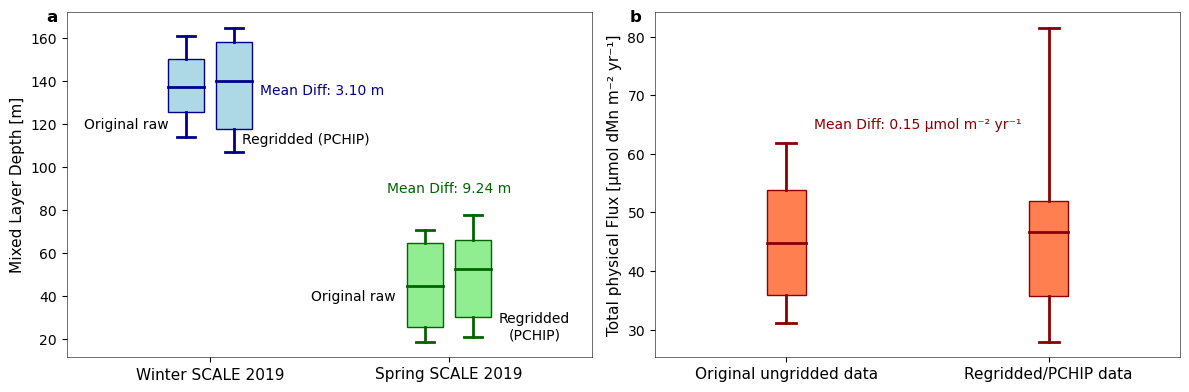

In [148]:

entrainment_data = WIN_Entrainment.values.flatten()
entrainment_data = entrainment_data[~np.isnan(entrainment_data)] -3.56 

SCALE_Ent = [50.09 - 4.43, 49.29 - 4.43, 35.56 - 4.43, 45.16 - 4.43, 66.32 - 4.43, 18.77 - 4.43, 94.18 - 4.43]


# Set up the figure with two subplots
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 2
np.random.seed(10)

fig, axs = plt.subplots(1, 2, figsize=[12, 4])  # Create two subplots side by side

# -- First subplot: MLD data --
ax = axs[0]

lon_range = (0, 14)  # Adjust this based on your data
lat_range = (-56, -35)  # Adjust this based on your data

# Filter MLD_df based on the longitude and latitude ranges
filtered_MLD_df = MLD_df[(MLD_df['Longitude'] >= lon_range[0]) & 
                          (MLD_df['Longitude'] <= lon_range[1]) & 
                          (MLD_df['Latitude'] >= lat_range[0]) & 
                          (MLD_df['Latitude'] <= lat_range[1])]

winter_months = [7, 8]  
spring_months = [10, 11]

# Define positions with very close spacing
winter_positions = [1, 1.2]  # Very close spacing for Winter boxplots
spring_positions = [2, 2.2]  # Very close spacing for Spring boxplots

SCALE_MLD_winter = SCALE_MLD['WinterMLD'].dropna()
SCALE_MLD_spring = SCALE_MLD['SpringMLD'].dropna()

MLD_df_winter = filtered_MLD_df[filtered_MLD_df['Month'].isin(winter_months)]['MLD_max'].dropna()
MLD_df_spring = filtered_MLD_df[filtered_MLD_df['Month'].isin(spring_months)]['MLD'].dropna()

# Define colors for the boxplots
winter_color_ScaleMLD = "lightblue"
winter_color_MLDdf = "lightblue"
spring_color_ScaleMLD = "lightgreen"
spring_color_MLDdf = "lightgreen"

# Create the boxplot for Winter MLD from SCALE_MLD
ax.boxplot([SCALE_MLD_winter],
           positions=[winter_positions[0]],
           patch_artist=True,
           boxprops=dict(facecolor=winter_color_ScaleMLD, color="darkblue"),
           medianprops=dict(color="darkblue", linewidth=2),
           whiskerprops=dict(color="darkblue", linewidth=2),
           capprops=dict(color="darkblue", linewidth=2),
           whis=[5, 95], showfliers=False)

# Create the boxplot for Winter MLD from MLD_df
ax.boxplot([MLD_df_winter],
           positions=[winter_positions[1]],
           patch_artist=True,
           boxprops=dict(facecolor=winter_color_MLDdf, color="darkblue"),
           medianprops=dict(color="darkblue", linewidth=2),
           whiskerprops=dict(color="darkblue", linewidth=2),
           capprops=dict(color="darkblue", linewidth=2),
           whis=[5, 95], showfliers=False)

# Create the boxplot for Spring MLD from SCALE_MLD
ax.boxplot([SCALE_MLD_spring],
           positions=[spring_positions[0]],
           patch_artist=True,
           boxprops=dict(facecolor=spring_color_ScaleMLD, color="darkgreen"),
           medianprops=dict(color="darkgreen", linewidth=2),
           whiskerprops=dict(color="darkgreen", linewidth=2),
           capprops=dict(color="darkgreen", linewidth=2),
           whis=[5, 95], showfliers=False)

# Create the boxplot for Spring MLD from MLD_df
ax.boxplot([MLD_df_spring],
           positions=[spring_positions[1]],
           patch_artist=True,
           boxprops=dict(facecolor=spring_color_MLDdf, color="darkgreen"),
           medianprops=dict(color="darkgreen", linewidth=2),
           whiskerprops=dict(color="darkgreen", linewidth=2),
           capprops=dict(color="darkgreen", linewidth=2),
           whis=[5, 95], showfliers=False)

# Set axis labels and title
ax.set_ylabel('Mixed Layer Depth [m]', fontsize=11)
ax.set_xticks([1.1,  2.1])  # Tick positions matching the boxplot positions
ax.set_xticklabels(['Winter SCALE 2019', 'Spring SCALE 2019'], fontsize=11)

# Add text for clarification
ax.text(0.75, 120, 'Original raw', fontsize=10, color='black', 
        verticalalignment='center', horizontalalignment='center')

ax.text(1.5, 113, 'Regridded (PCHIP)', fontsize=10, color='black', 
        verticalalignment='center', horizontalalignment='center')

# Add text annotations for winter data
ax.text(1.57, 136, f"Mean Diff: {mean_diff_winter:.2f} m",
        fontsize=10, color='darkblue', verticalalignment='center', horizontalalignment='center')

# Add text annotations for spring data
ax.text(2.1, 90, f"Mean Diff: {mean_diff_spring:.2f} m",
        fontsize=10, color='darkgreen', verticalalignment='center', horizontalalignment='center')


ax.text(1.7, 40, 'Original raw', fontsize=10, color='black', 
        verticalalignment='center', horizontalalignment='center')

ax.text(2.46, 26, 'Regridded\n(PCHIP)', fontsize=10, color='black', 
        verticalalignment='center', horizontalalignment='center')

# Adjust the border thickness of the plot
for spine in ax.spines.values():
    spine.set_linewidth(0.4)

# -- Second subplot: Entrainment data --
ax = axs[1]

# Combine both datasets into a list for boxplot comparison
data_to_plot = [ SCALE_Ent,entrainment_data]

# Create a boxplot with both datasets
ax.boxplot(data_to_plot, vert=True, patch_artist=True,
           boxprops=dict(facecolor='coral', color="darkred"),
           medianprops=dict(color="darkred", linewidth=2),
           whiskerprops=dict(color="darkred", linewidth=2),
           capprops=dict(color="darkred", linewidth=2),
           whis=[5, 95], showfliers=False)

# Customize labels and title
ax.set_xticks([1, 2])
ax.set_xticklabels(['Original ungridded data','Regridded/PCHIP data'], fontsize=11)
ax.set_ylabel('Total physical Flux [µmol dMn m⁻² yr⁻¹]', fontsize=11)
for spine in ax.spines.values():
    spine.set_linewidth(0.4)
    
fig.text(0.047, 0.95, 'a', fontsize=12, weight='bold', va='center', ha='center', color='black')
fig.text(0.534, 0.95, 'b', fontsize=12, weight='bold', va='center', ha='center', color='black')

# Annotate the plot with the mean difference and p-value at the specified position (1.5, 120)
ax.text(1.5, 65,  # Exact position for the annotation
        f"Mean Diff: {mean_diff_entrainment:.2f} µmol m⁻² yr⁻¹",
        fontsize=10, color='darkred', ha='center', va='center')


# Adjust layout for tight spacing
plt.tight_layout()



#plt.tight_layout()
plt.savefig('Sanity_Comparison.png', bbox_inches='tight', dpi=499)

In [136]:
depth_diff = np.diff(filtered_ds.Depth.values)
depth_mask = filtered_ds.Depth <= filtered_ds.MLD_max
mn_diff = filtered_ds.Mn.where(depth_mask).diff('Depth').mean('Month')
mn_grad = ((mn_diff / depth_diff) * 1000).where(depth_mask).max('Depth')
ds_grad_mn3 = mn_grad.coarsen(Latitude=3, Longitude=3, boundary='trim').mean()

depth_diff = np.diff(filtered_ds.Depth.values)
depth_mask = filtered_ds.Depth <= filtered_ds.MLD_max
fe_diff = filtered_ds.Fe.where(depth_mask).diff('Depth').mean('Month')
fe_grad = ((fe_diff / depth_diff) * 1000).where(depth_mask).max('Depth')
ds_grad_fe3 = fe_grad.coarsen(Latitude=3, Longitude=3, boundary='trim').mean()
Kz1 = 0.001
Kz2 = 0.0001
Kz3 = 0.00001

# Calculate diapycnal diffusion for each Kz
diapycnal_diffusion_1 = (Kz1 * ds_grad_mn3 * 31536000) / 1000
diapycnal_diffusion_2 = (Kz2 * ds_grad_mn3 * 31536000) / 1000
diapycnal_diffusion_3 = (Kz3 * ds_grad_mn3 * 31536000) / 1000
diapycnal_diffusion_mean = xr.concat(
    [diapycnal_diffusion_1, diapycnal_diffusion_2, diapycnal_diffusion_3], 
    dim="new_dim"
).mean(dim="new_dim")

diapycnal_diffusion_std = xr.concat(
    [diapycnal_diffusion_1, diapycnal_diffusion_2, diapycnal_diffusion_3], 
    dim="new_dim"
).std(dim="new_dim")





C:\Users\Thape\anaconda3\new ann\envs\tesha\Lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
